In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import pycountry
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import box

In [2]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Find all BOC/EOC files
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
pattern  = os.path.join(base_dir, "*", "*", "solar_drought_events_*.csv")

file_paths = glob.glob(pattern)
if not file_paths:
    raise FileNotFoundError(f"No files found matching {pattern!r}")
print(file_paths)

['/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CanESM5_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/CMCC-CM2-SR5_1x1grid/historical/solar_drought_events_BOC.csv', '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/HadGEM3-GC31-MM_1x1grid/ssp585/solar_drought_events_EOC.csv', '/work/user

In [3]:
# 2) Read & concatenate, extracting model and period
records = []
for fp in file_paths:
    df = pd.read_csv(fp)
    
    # split into components
    parts = os.path.normpath(fp).split(os.sep)
    # find the index of "power"
    i = parts.index("power")
    # the model folder is exactly one step after "power"
    model_dir = parts[i+1]            # e.g. "ACCESS-CM2_1x1grid"
    model     = model_dir.split("_")[0]  # -> "ACCESS-CM2"

    
    # filename ends with "_BOC.csv" or "_EOC.csv"
    period = os.path.splitext(os.path.basename(fp))[0].split("_")[-1]
    
    df["model"]  = model
    df["period"] = period
    records.append(df)

all_events = pd.concat(records, ignore_index=True)
print(all_events)


                    model period  year  season   lat   lon  start_month  \
0                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
1                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
2                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
3                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
4                 CanESM5    EOC  2065  Winter  35.0 -11.0            1   
...                   ...    ...   ...     ...   ...   ...          ...   
29483224  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483225  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483226  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483227  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   
29483228  HadGEM3-GC31-LL    BOC  2014  Autumn  64.0  25.0           11   

          duration dur_bin  
0                1     0-1  
1                1     0-1  
2           

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
df = all_events  

# 2) Build a GeoDataFrame of event points
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(lon, lat) for lon, lat in zip(df.lon, df.lat)],
    crs="EPSG:4326"
)

# 3) Load Natural Earth country polygons
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
).to_crs("EPSG:4326")

# 4) Fix any ISO codes if needed
world.loc[world.NAME_LONG == 'France', 'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG == 'United Kingdom', 'ISO_A2'] = 'GB'
# … you can add more fixes here if you discover mismatches …

# 5) Keep only the six you care about
target_iso2 = ['ES','FR','DE','PL','GB','IT']
countries = world[world['ISO_A2'].isin(target_iso2)].copy()

# 6) Spatial‐join your events to those country polygons
events_with_country = gpd.sjoin(
    gdf, 
    countries[['ISO_A2','geometry']], 
    how='inner', 
    predicate='within'
).rename(columns={'ISO_A2':'country_code'})

# 7) (Optional) Map codes to names
code_to_name = {
    'ES':'Spain','FR':'France','DE':'Germany',
    'PL':'Poland','GB':'United Kingdom','IT':'Italy'
}
events_with_country['country'] = events_with_country['country_code'].map(code_to_name)

In [ ]:
events_with_country

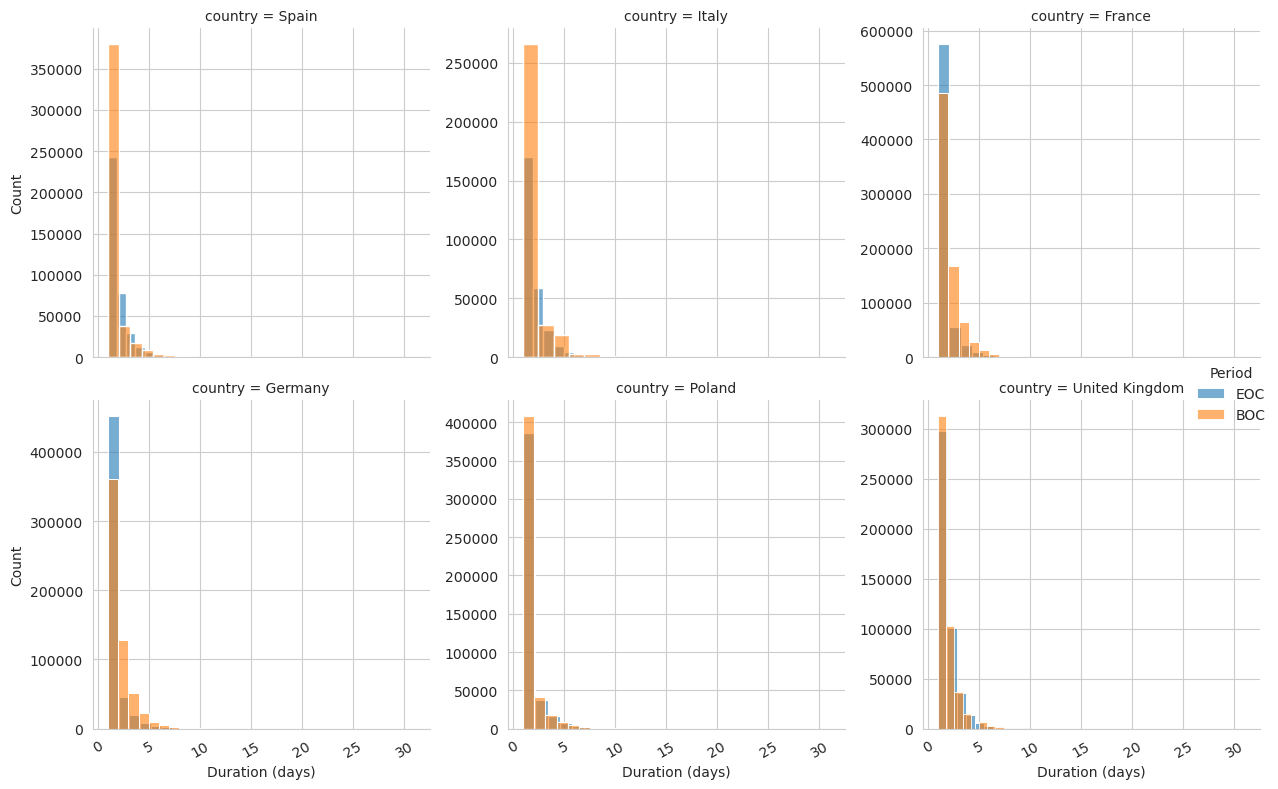

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# adjust bins & alpha as you like
g = sns.FacetGrid(
    events_with_country,
    col="country",
    hue="period",
    col_wrap=3,
    sharex=True,
    sharey=False,
    height=4
)
g.map(
    sns.histplot,
    "duration",
    bins=20,
    alpha=0.6,
    multiple="layer",
    edgecolor="w"
)
g.add_legend(title="Period")
g.set_axis_labels("Duration (days)", "Count")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

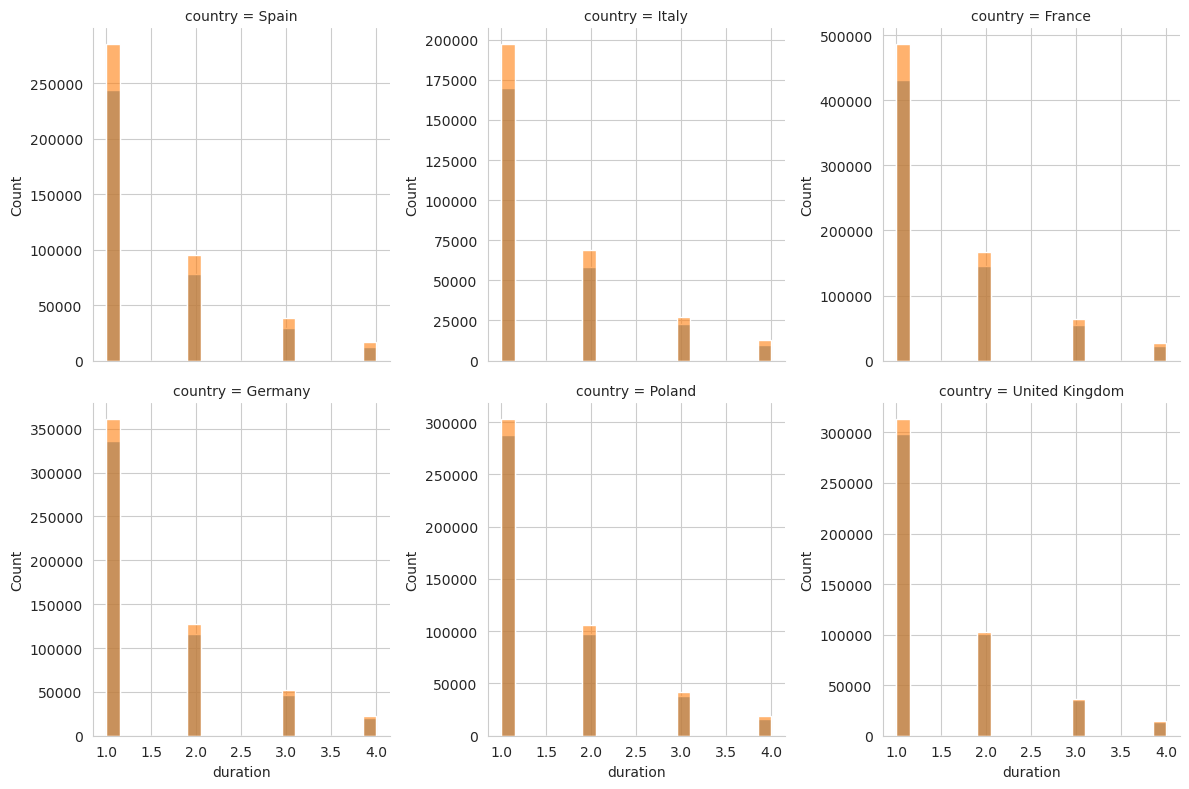

In [9]:
# …above your FacetGrid call…

# 1) compute the 95th‐percentile per country×period
p95 = (
    events_with_country
      .groupby(["country","period"])["duration"]
      .quantile(0.95)
      .rename("p95")
      .reset_index()
)

# 2) merge it back and filter
df95 = (
    events_with_country
      .merge(p95, on=["country","period"])
      .query("duration <= p95")
      .drop(columns="p95")
)

# 3) plot only the filtered data
g = sns.FacetGrid(
    df95,
    col="country",
    hue="period",
    col_wrap=3,
    sharex=True,
    sharey=False,
    height=4
)
g.map(
    sns.histplot,
    "duration",
    bins=20,
    alpha=0.6,
    multiple="layer",
    edgecolor="w"
)
# …the rest of your plotting code…

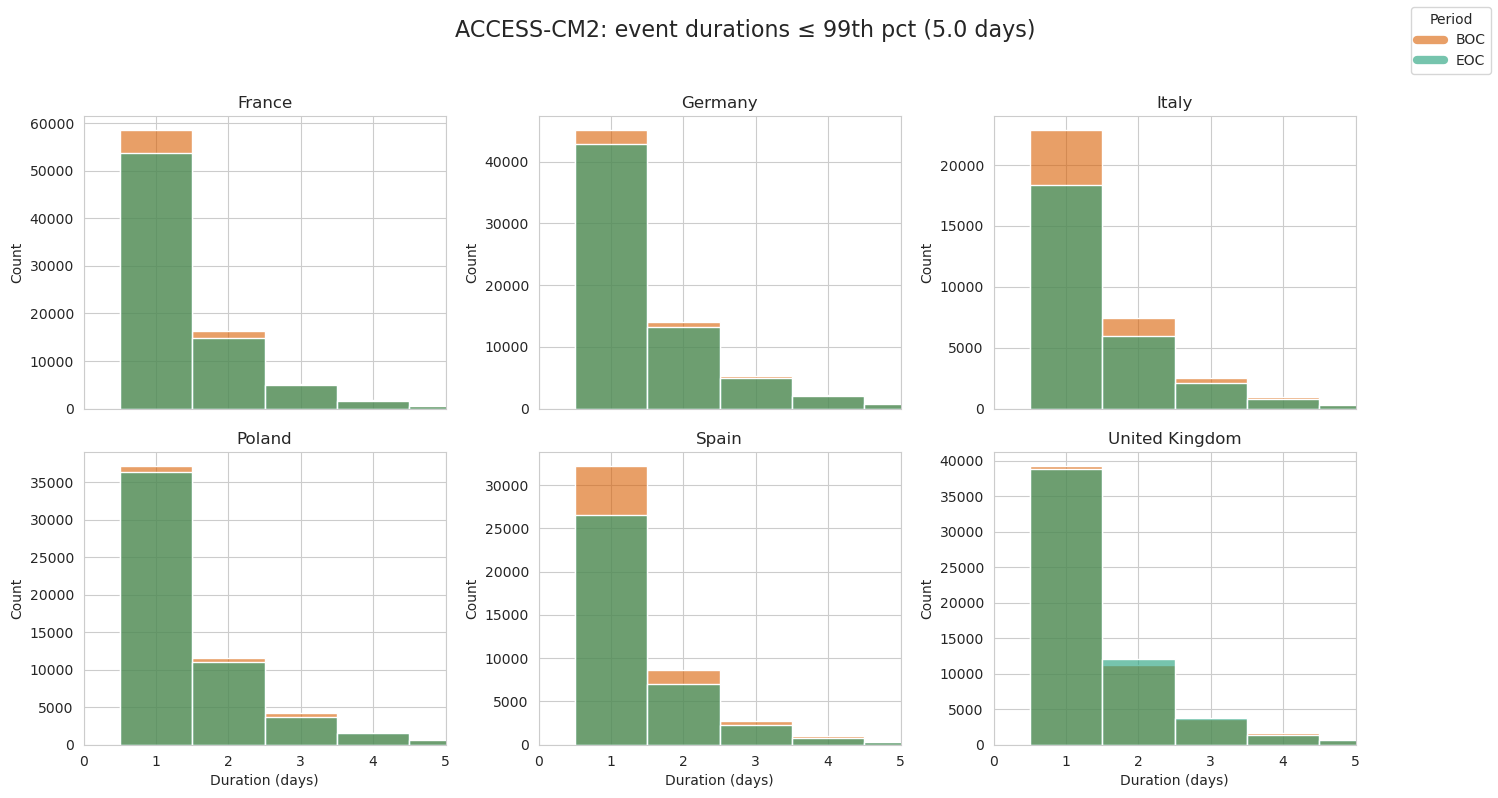

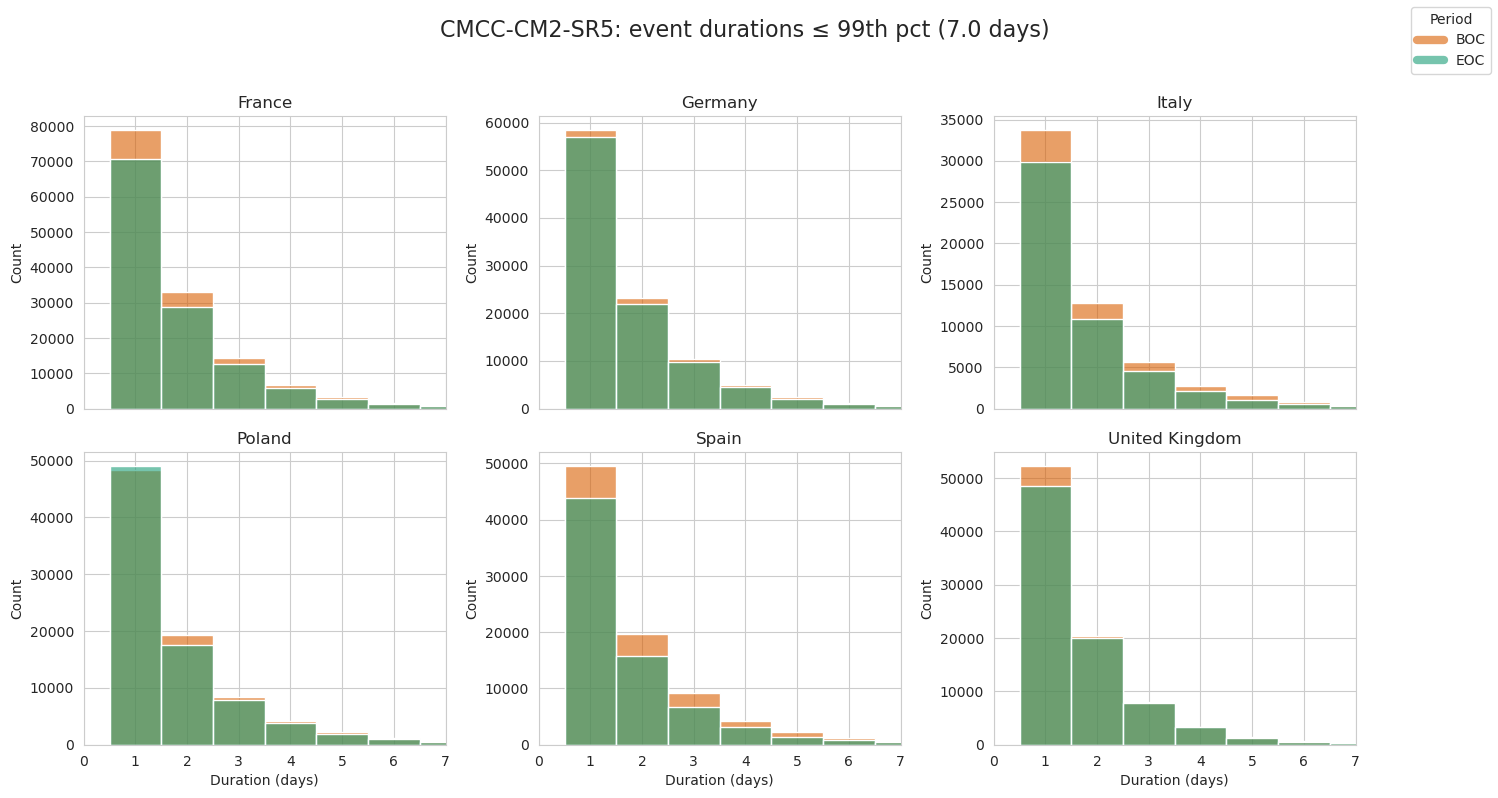

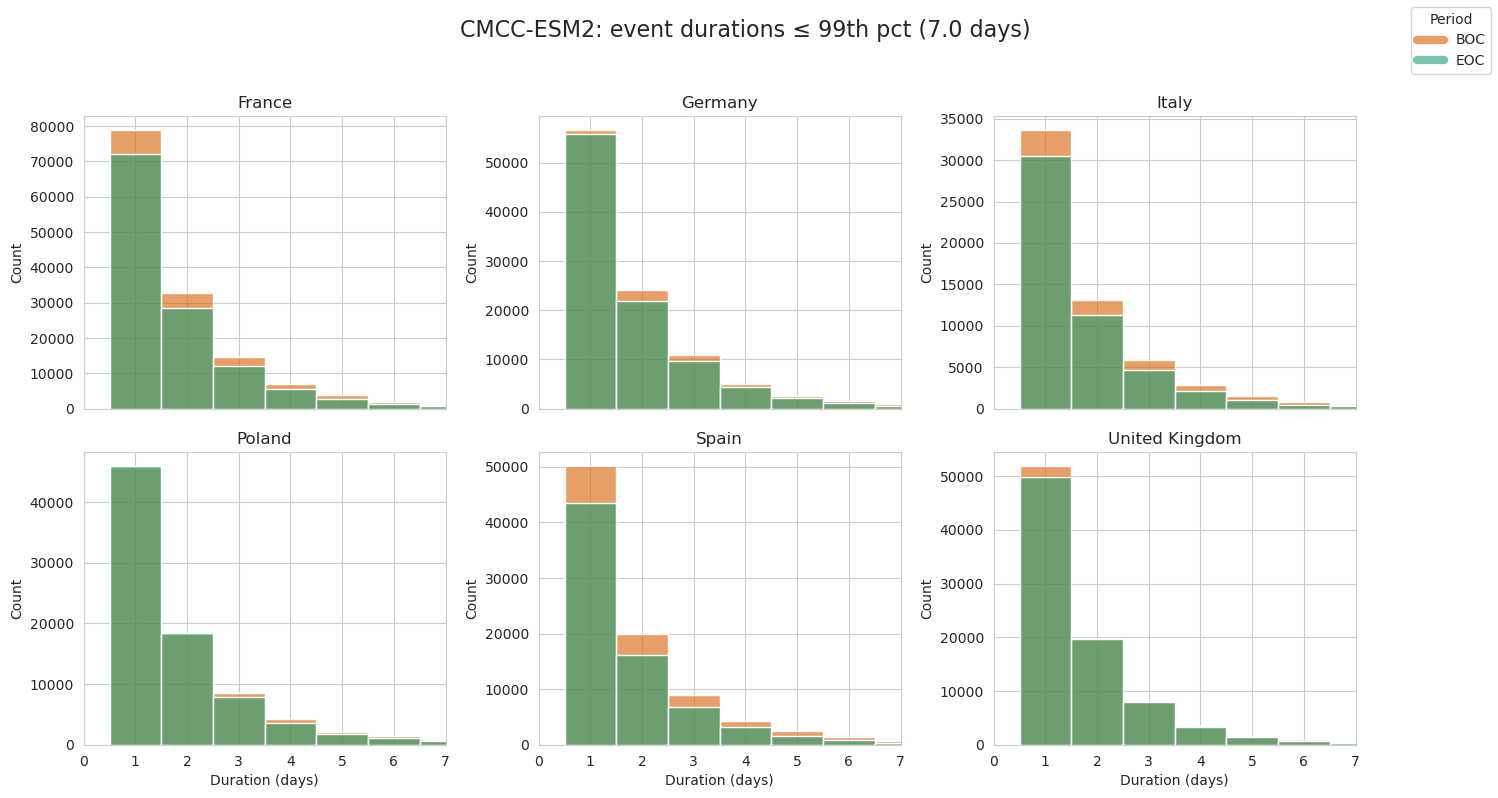

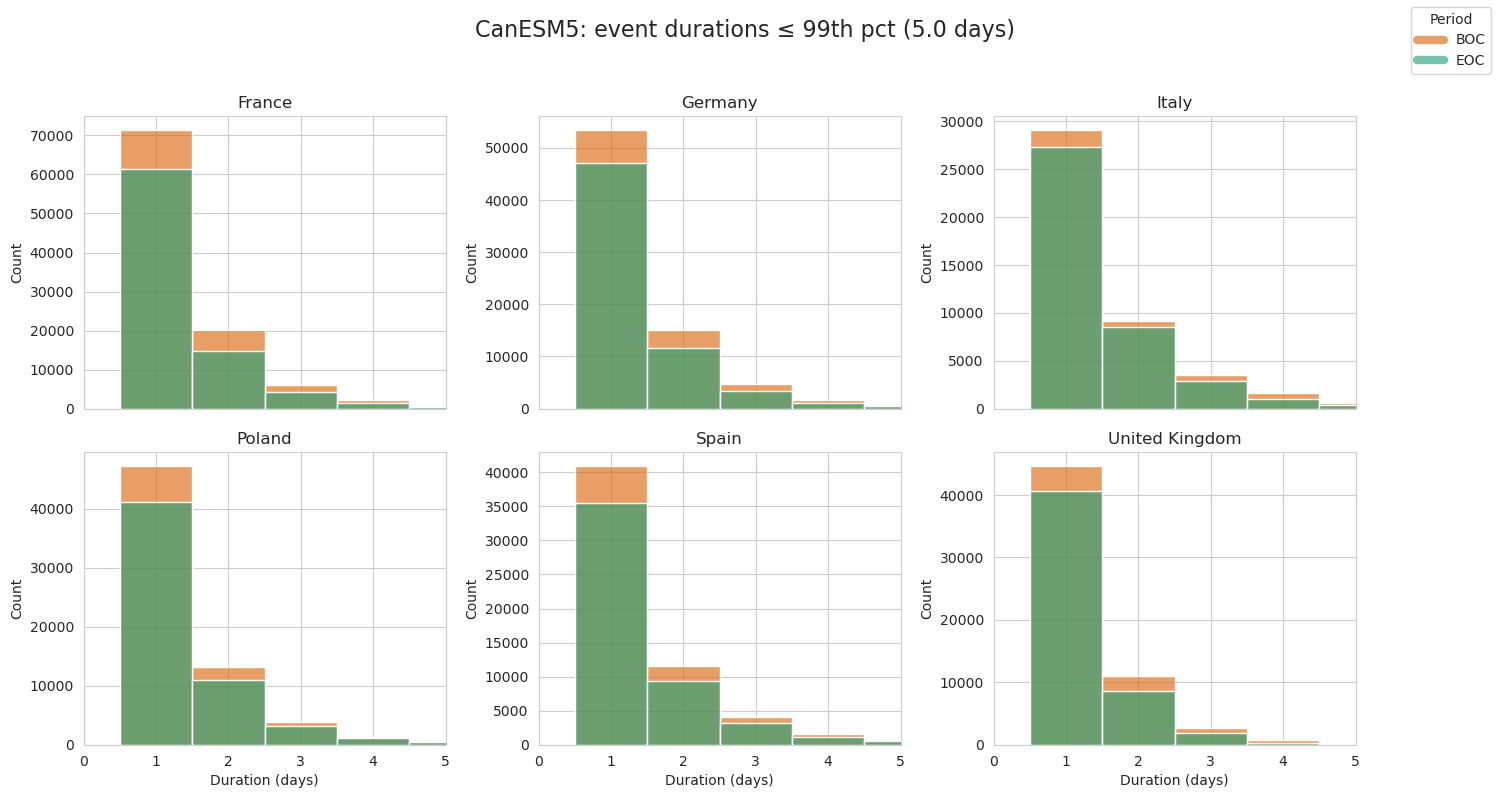

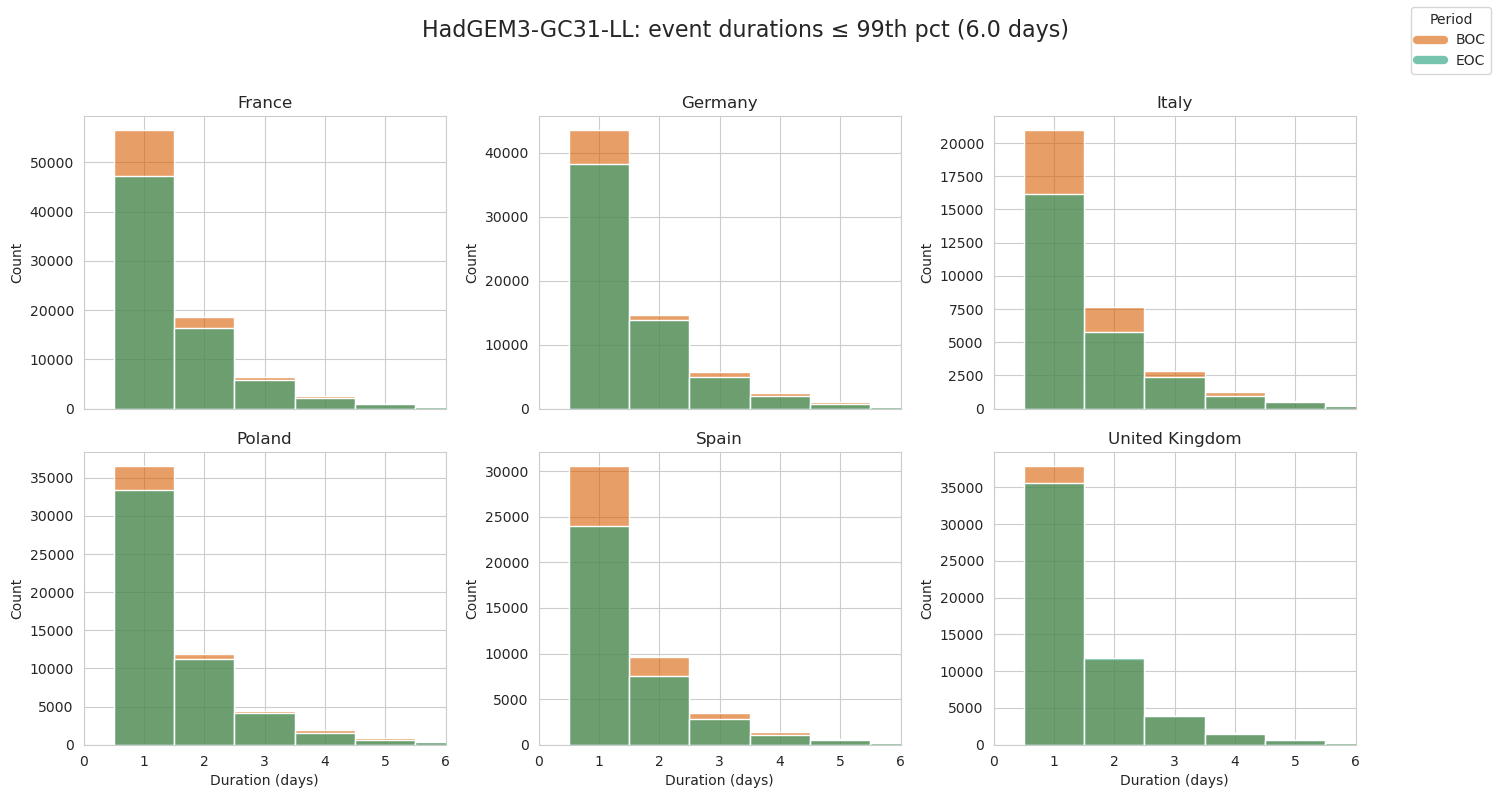

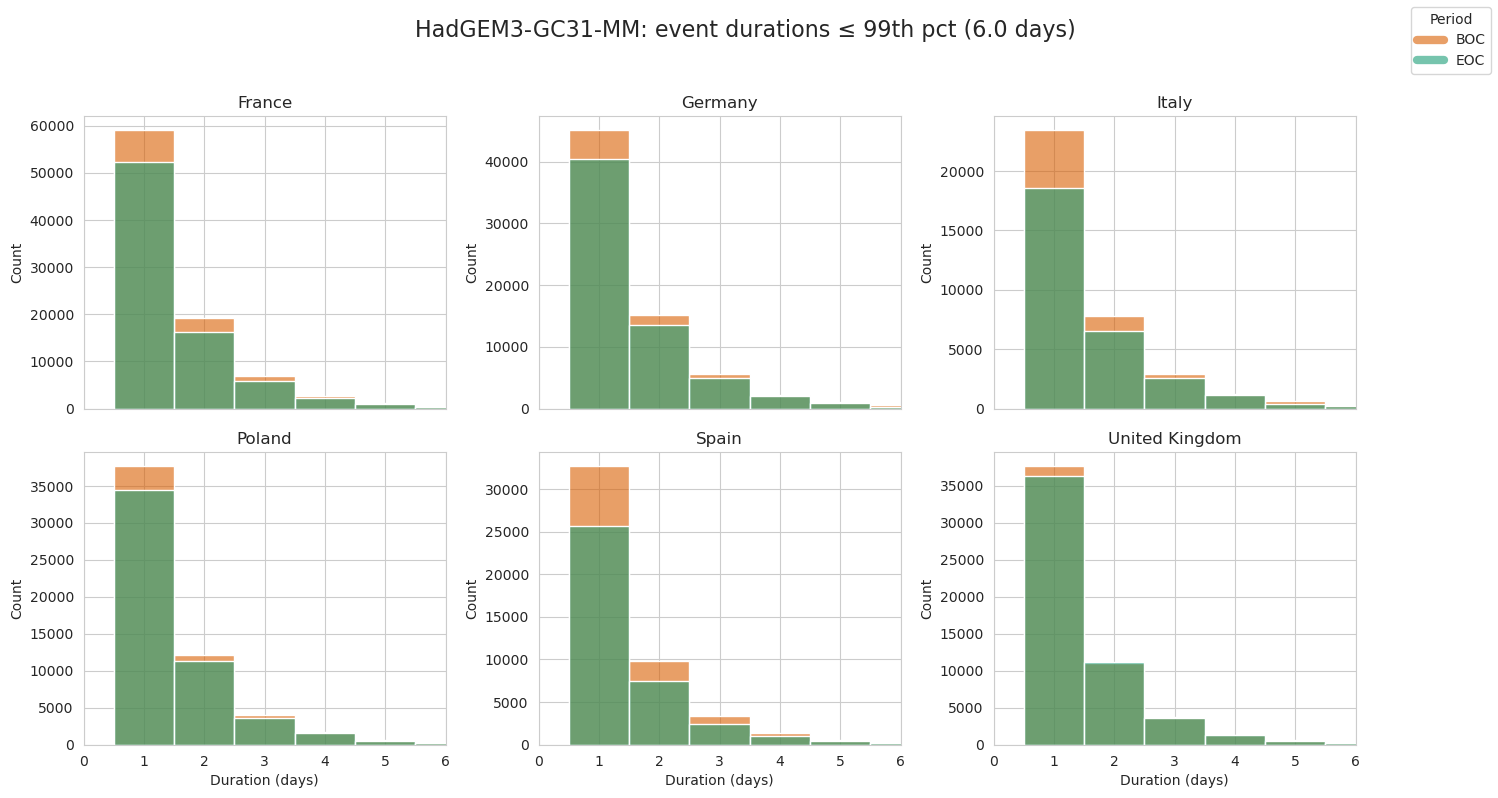

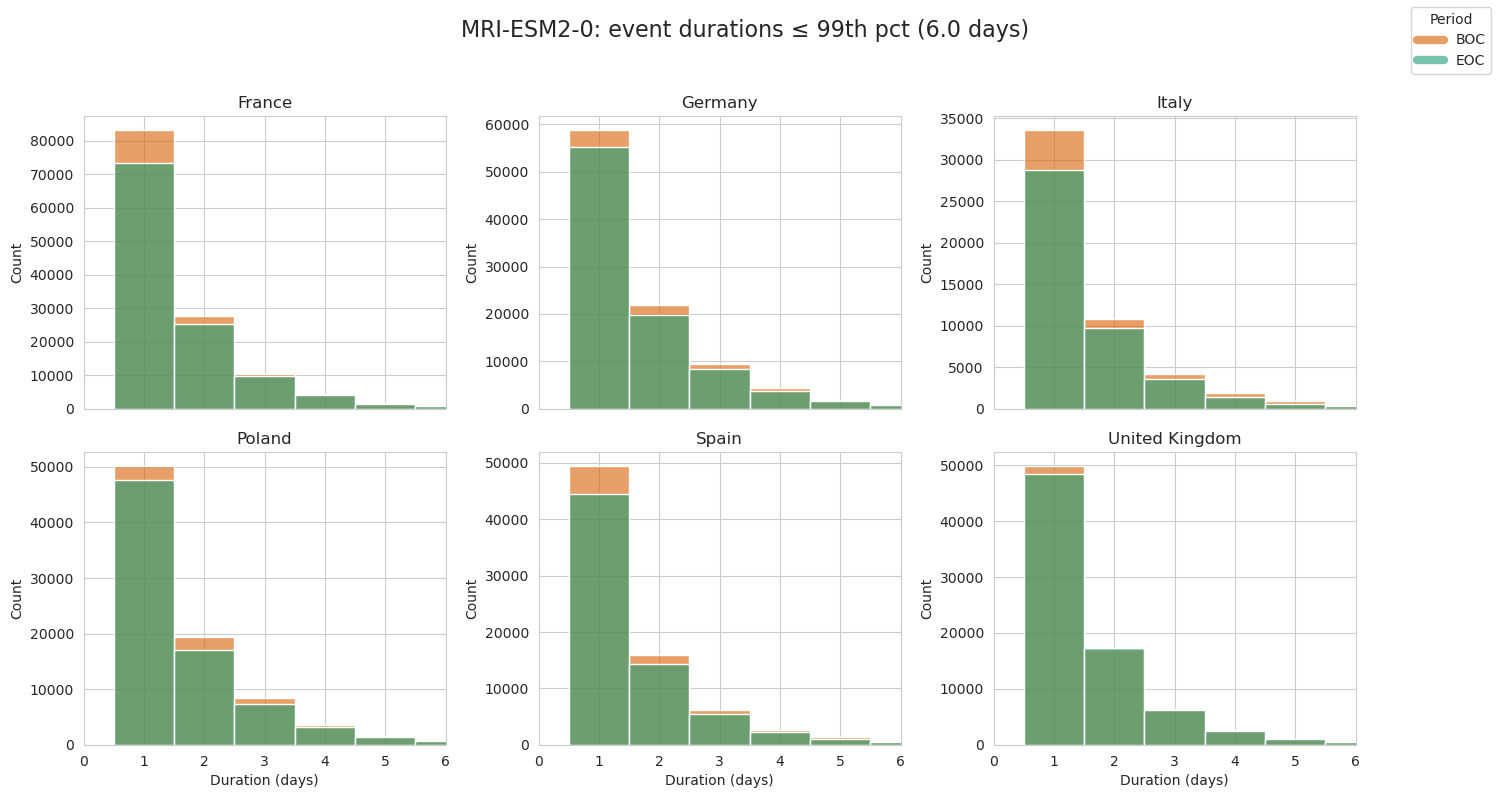

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# assume events_with_country has ['model','country','period','duration']
models    = sorted(events_with_country['model'].unique())
countries = sorted(events_with_country['country'].unique())
colors    = {'BOC':'#d95f02','EOC':'#1b9e77'}

for model in models:
    # 1) filter to this model & compute 99th percentile
    dfm   = events_with_country[events_with_country['model']==model]
    if dfm.empty:
        continue
    p99   = dfm['duration'].quantile(0.99)
    dfcut = dfm[dfm['duration']<=p99]

    # 2) setup 2×3 grid of subplots, one per country
    fig, axes = plt.subplots(2, 3,
                             figsize=(15, 8),
                             sharex=True,
                             sharey=False)
    axes = axes.flatten()

    for ax, country in zip(axes, countries):
        dfc = dfcut[dfcut['country']==country]
        if dfc.empty:
            ax.set_title(country + "\n(no data)")
            continue

        # 3) discrete histplot of durations, colored by period
        sns.histplot(
            data=dfc,
            x='duration',
            discrete=True,
            hue='period',
            palette=colors,
            multiple='layer',
            alpha=0.6,
            edgecolor='w',
            ax=ax,
            legend=False     # suppress per‐subplot legend
        )

        ax.set_title(country)
        ax.set_xlim(0, p99)
        ax.set_ylabel("Count")
        ax.set_xlabel("Duration (days)")

    # 4) single legend & title for the figure
    handles = [plt.Line2D([],[], color=col, lw=6, alpha=0.6)
               for col in colors.values()]
    labels  = list(colors.keys())
    fig.legend(handles, labels,
               title="Period",
               loc='upper right',
               frameon=True)
    fig.suptitle(f"{model}: event durations ≤ 99th pct ({p99:.1f} days)",
                 fontsize=16, y=0.98)

    plt.tight_layout(rect=[0,0,0.92,0.95])
    plt.show()

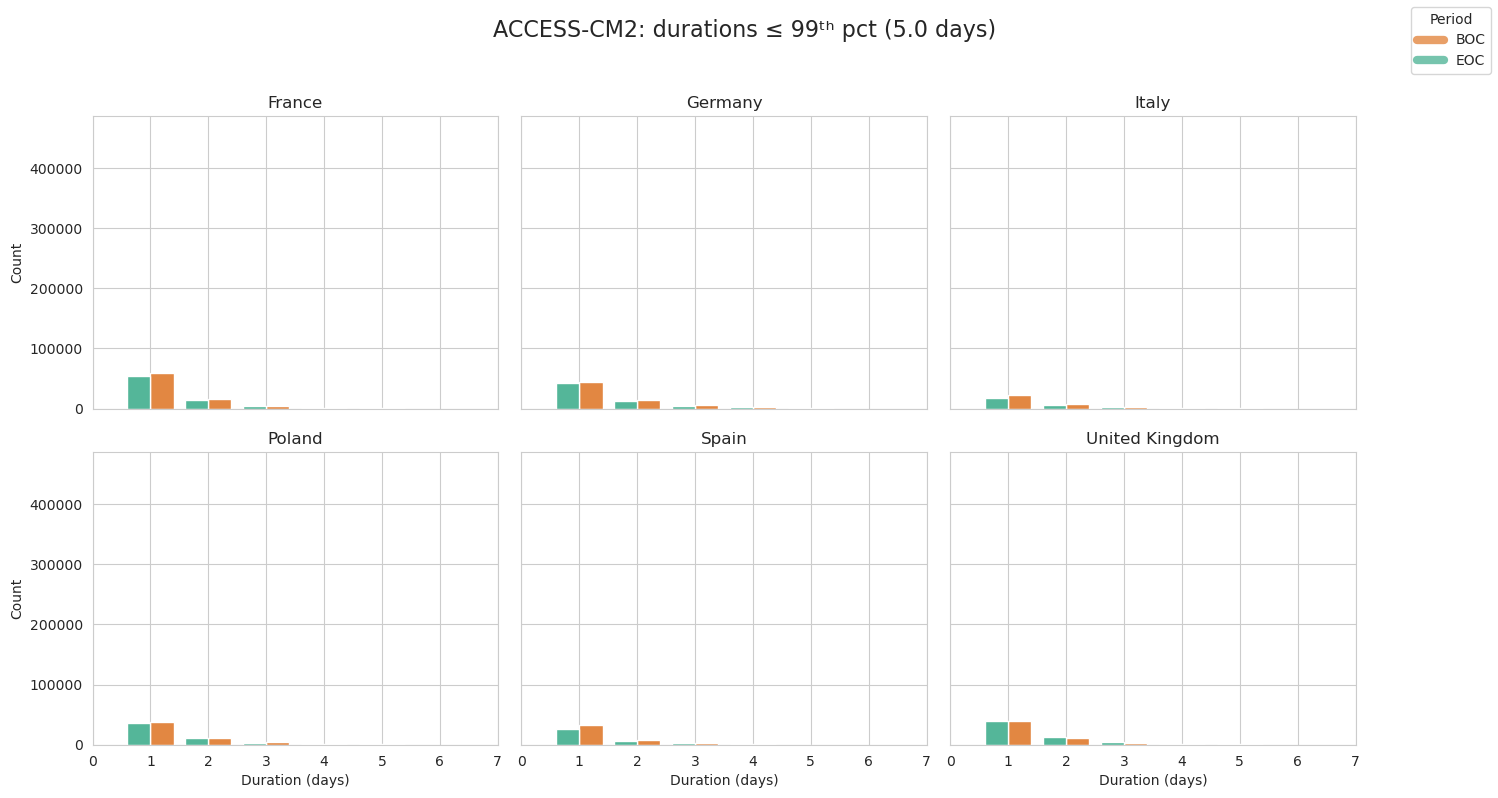

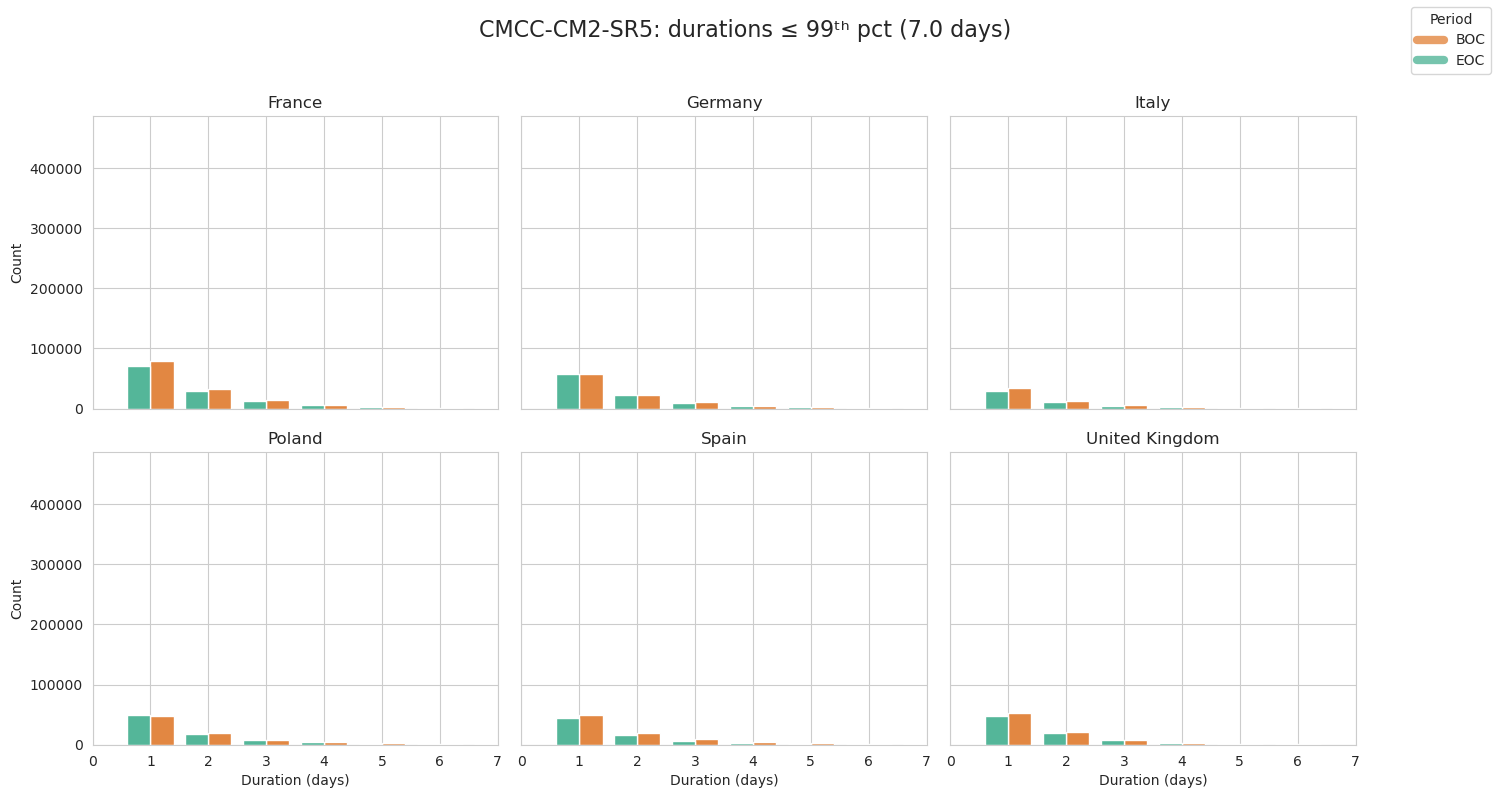

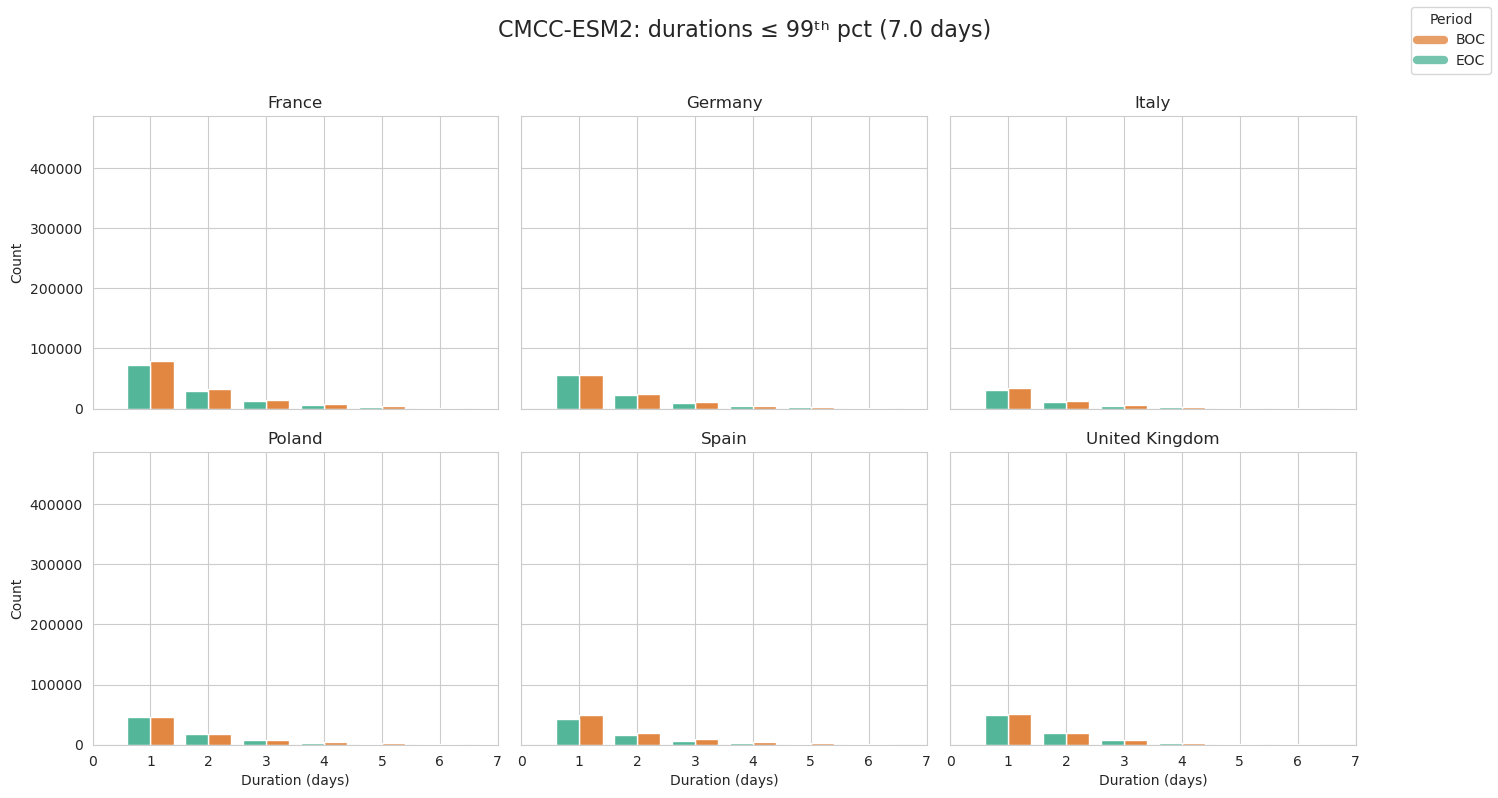

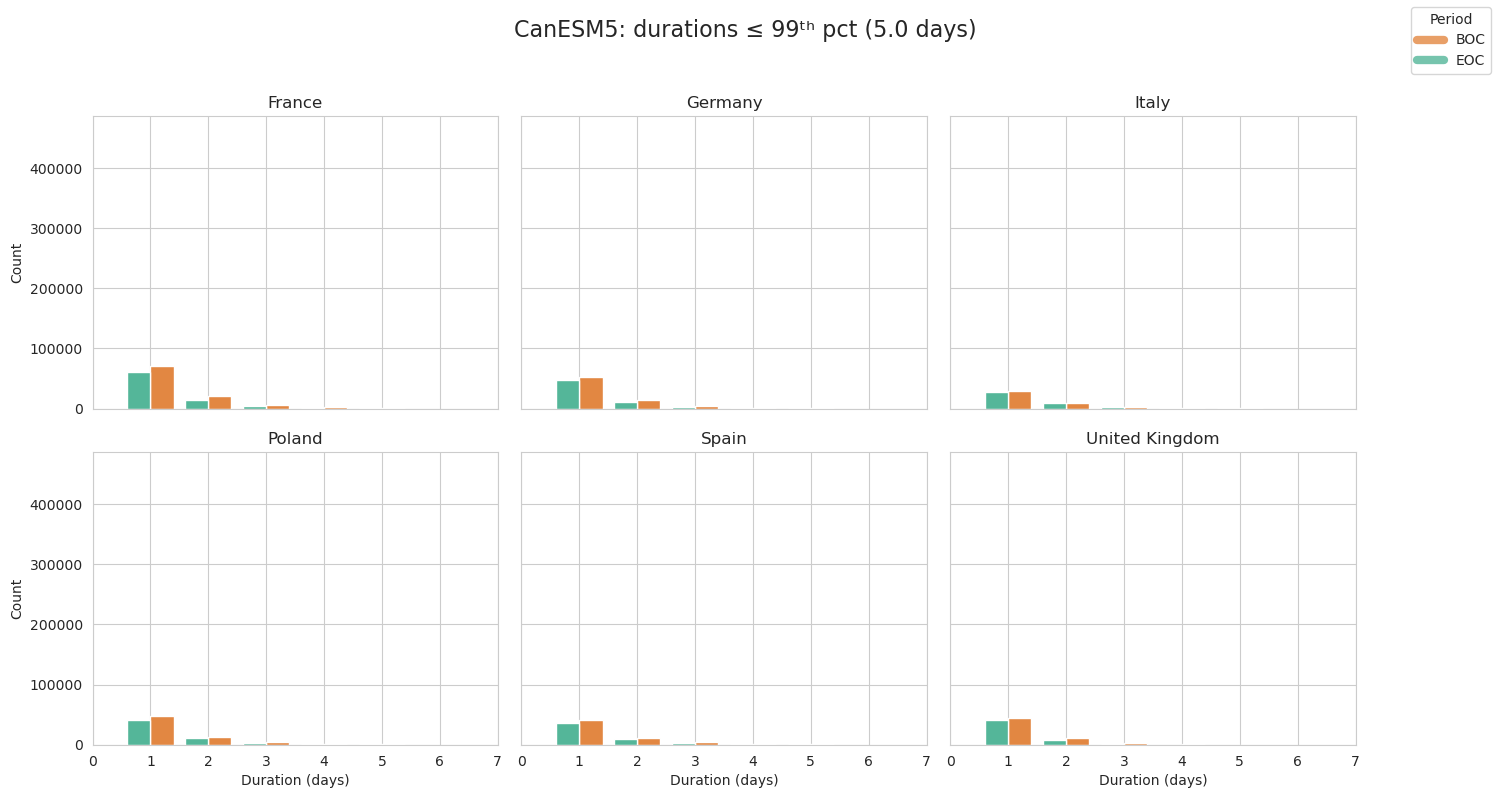

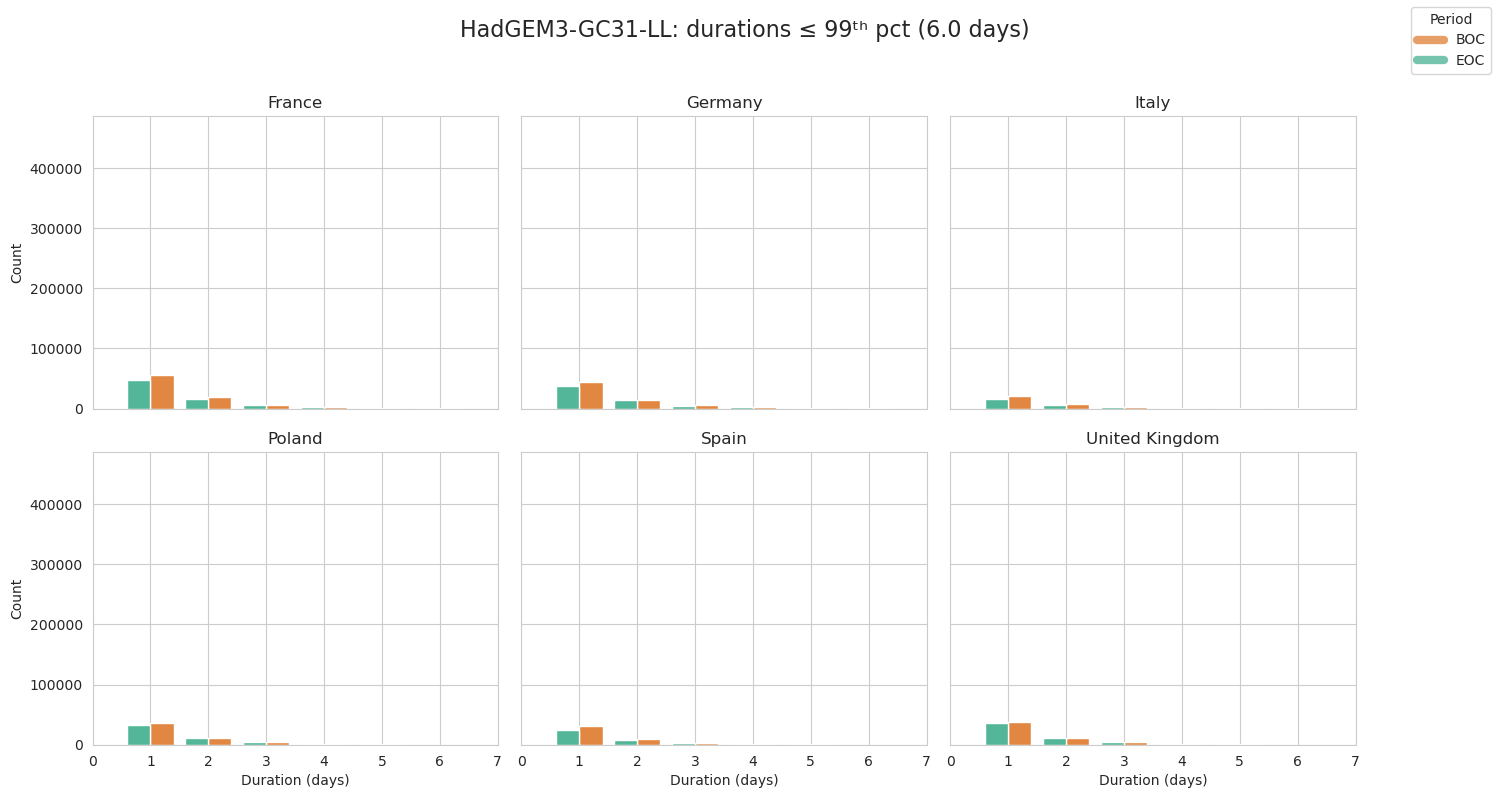

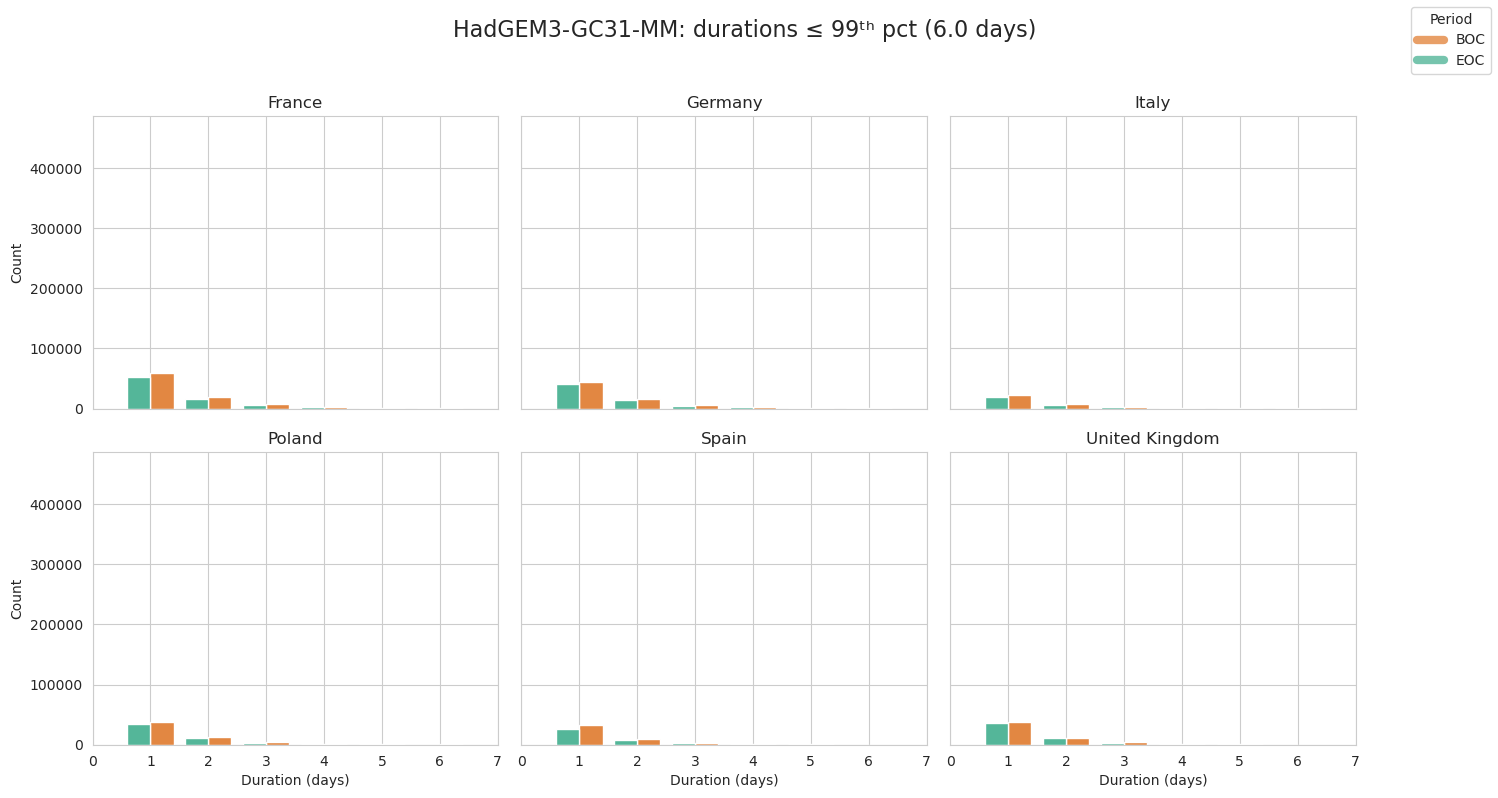

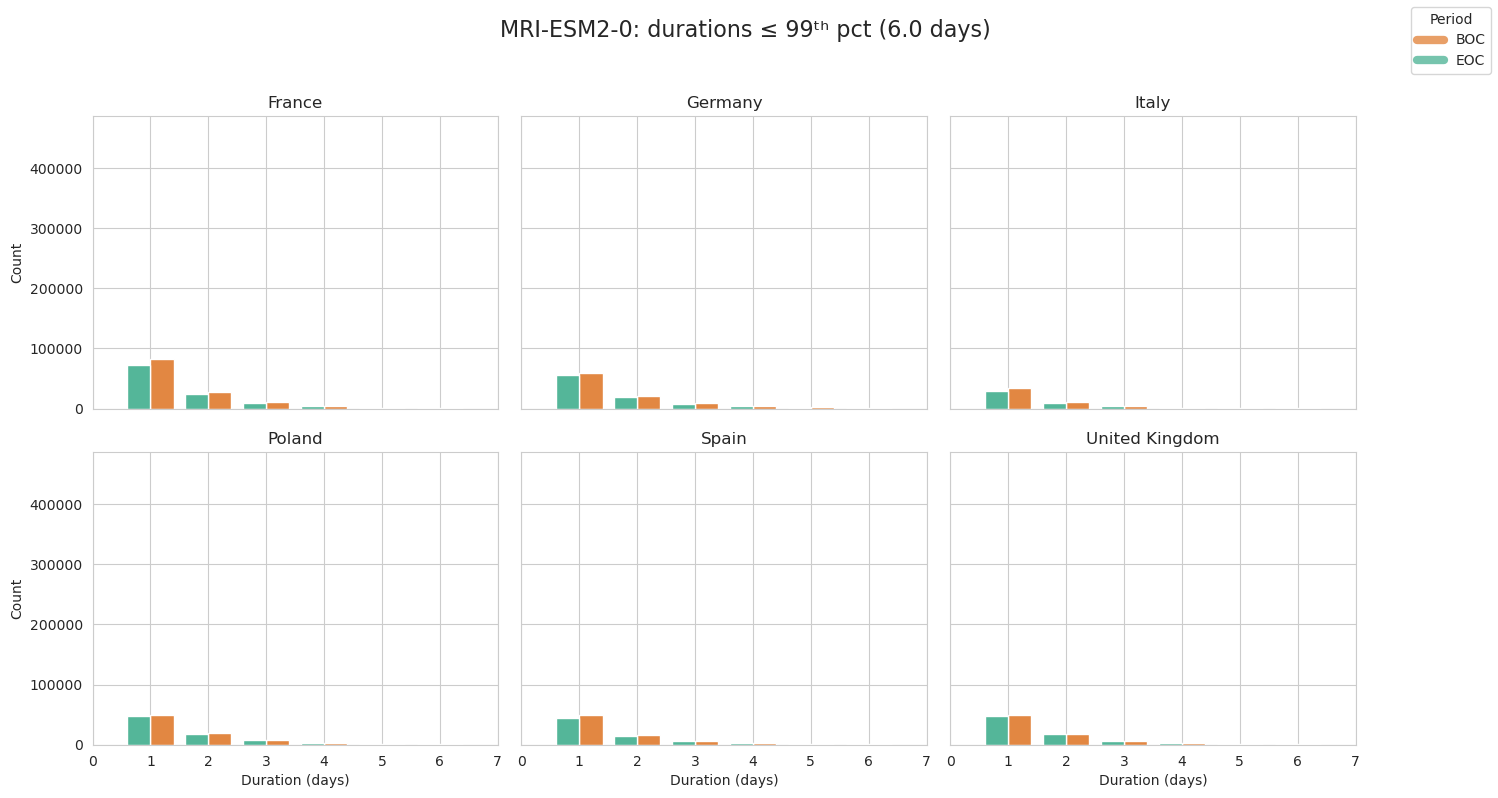

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

models    = sorted(events_with_country['model'].unique())
countries = sorted(events_with_country['country'].unique())
colors    = {'BOC':'#d95f02','EOC':'#1b9e77'}

# 0) precompute global cut‐off & binning
#    (max of all model-specific p99's)
model_p99s    = events_with_country.groupby('model')['duration'] \
                                   .quantile(0.99)
global_p99    = model_p99s.max()
bins          = np.arange(0, global_p99 + 1, 1)

# 1) precompute global ymax for any country/period up to global_p99
df_global_cut = events_with_country[
    events_with_country['duration'] <= global_p99
]
max_counts = []
for country in countries:
    for period in colors:
        vals = df_global_cut.loc[
            (df_global_cut['country']==country) &
            (df_global_cut['period']==period),
            'duration'
        ]
        if len(vals):
            hist, _ = np.histogram(vals, bins=bins)
            max_counts.append(hist.max())
global_ymax = max(max_counts) if max_counts else None

# 2) loop over models
for model in models:
    dfm   = events_with_country[events_with_country['model']==model]
    if dfm.empty:
        continue

    # model-specific 99th percentile & cut
    p99   = dfm['duration'].quantile(0.99)
    dfcut = dfm[dfm['duration'] <= p99]

    # 3) 2×3 grid of countries, shared x & y
    fig, axes = plt.subplots(2, 3,
                             figsize=(15, 8),
                             sharex=True,
                             sharey=True)
    axes = axes.flatten()

    for ax, country in zip(axes, countries):
        dfc = dfcut[dfcut['country'] == country]
        if dfc.empty:
            ax.set_title(f"{country}\n(no data)")
            continue

        sns.histplot(
            data=dfc,
            x='duration',
            discrete=True,
            hue='period',
            palette=colors,
            multiple='dodge',
            shrink=0.8,
            bins=bins,
            ax=ax,
            legend=False
        )

        ax.set_title(country)
        ax.set_xlim(0, global_p99)
        if global_ymax is not None:
            ax.set_ylim(0, global_ymax)
        ax.set_xlabel("Duration (days)")
        ax.set_ylabel("Count")

    # 4) common legend + title
    handles = [
        plt.Line2D([],[], color=col, lw=6, alpha=0.6)
        for col in colors.values()
    ]
    labels = list(colors.keys())
    fig.legend(handles, labels,
               title="Period",
               loc='upper right',
               frameon=True)
    fig.suptitle(
        f"{model}: durations ≤ 99ᵗʰ pct ({p99:.1f} days)",
        fontsize=16, y=0.98
    )

    plt.tight_layout(rect=[0,0,0.92,0.95])
    plt.show()

In [19]:
# …imports & models,countries,colors…

# 0a) precompute global cut‐off & bins (unchanged)
model_p99s = events_with_country.groupby('model')['duration'].quantile(0.99)
global_p99 = model_p99s.max()
bins       = np.arange(0, global_p99 + 1, 1)

# 0b) compute a true global_ymax by scanning *each* model's own histograms
all_max = []
for model in models:
    dfm   = events_with_country[events_with_country['model']==model]
    if dfm.empty: 
        continue
    p99   = dfm['duration'].quantile(0.99)
    dfcut = dfm[dfm['duration'] <= p99]
    for country in countries:
        for period in colors:
            vals = dfcut.loc[
                (dfcut['country']==country) & 
                (dfcut['period']==period),
                'duration'
            ]
            if len(vals):
                hist, _ = np.histogram(vals, bins=bins)
                all_max.append(hist.max())
global_ymax = max(all_max) if all_max else None

# …now go into your “for model in models:” loop…

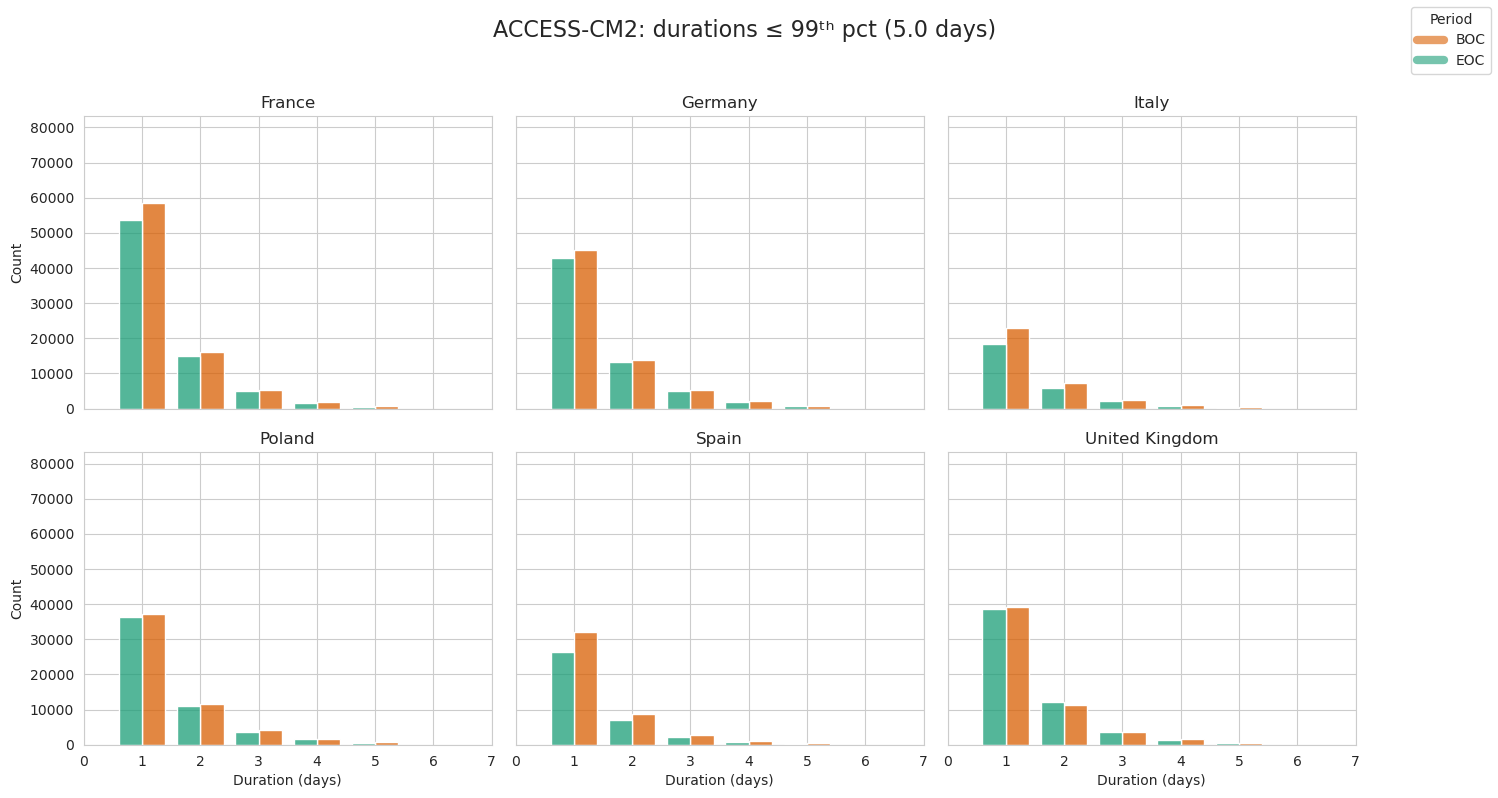

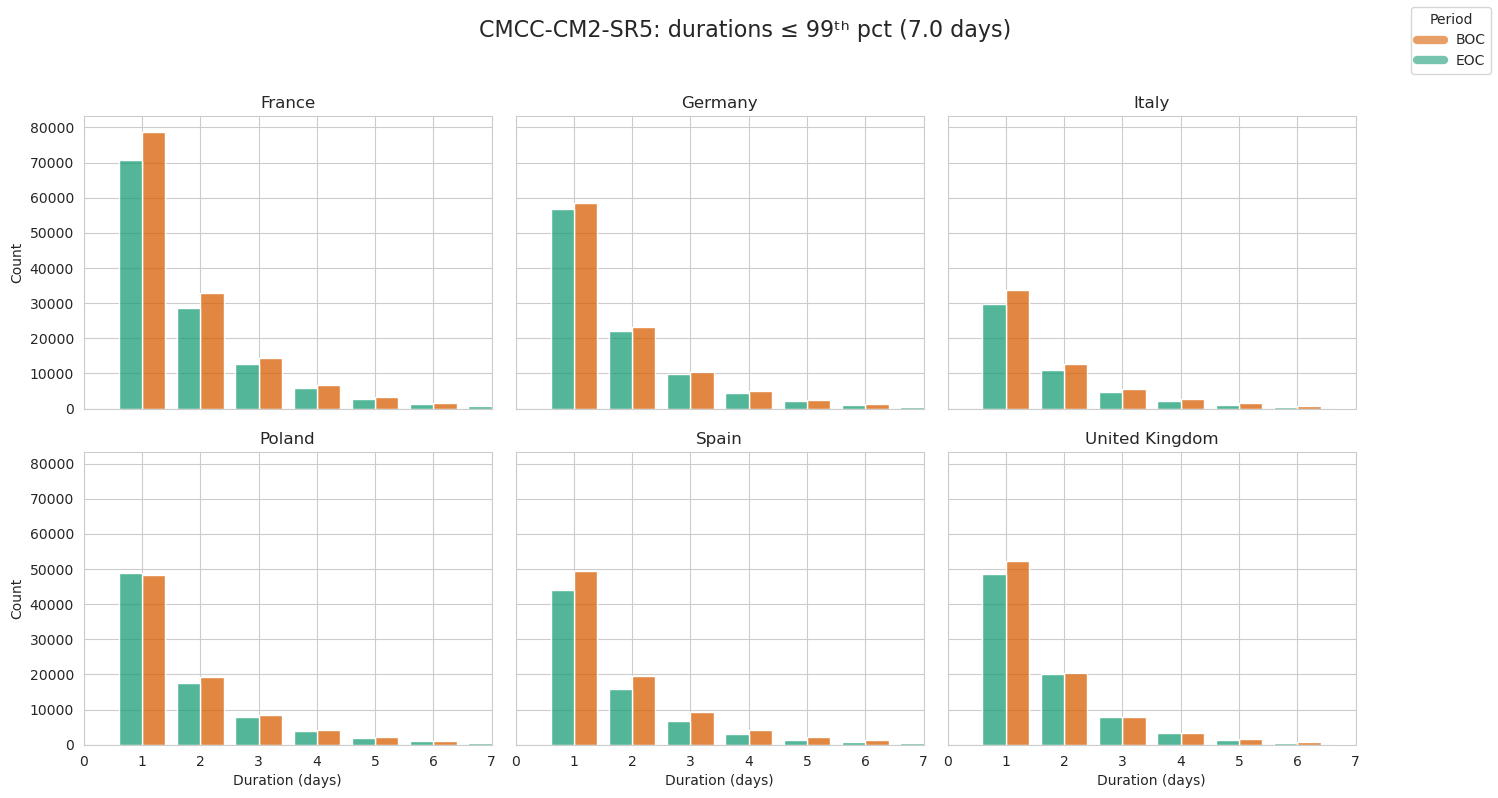

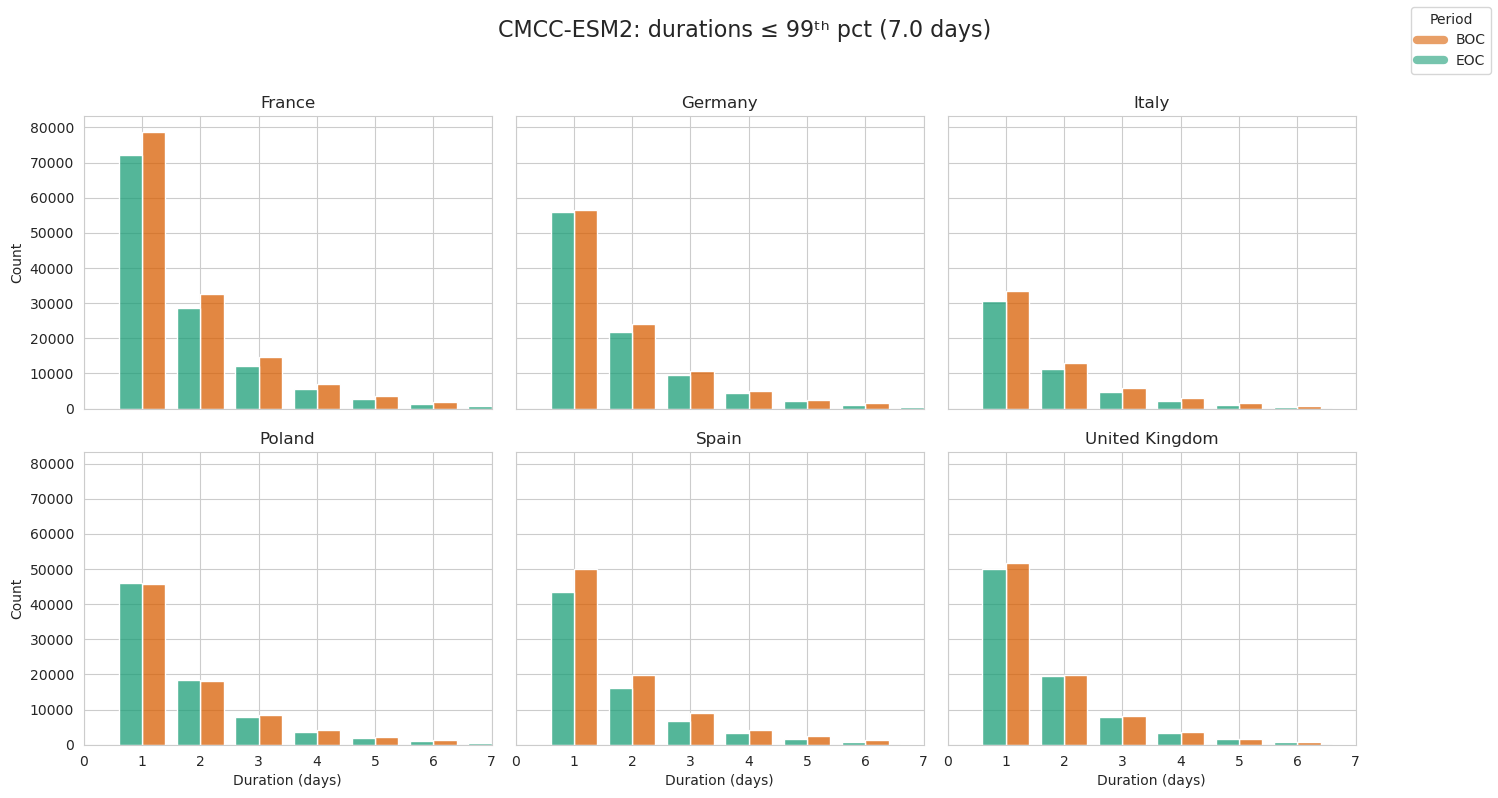

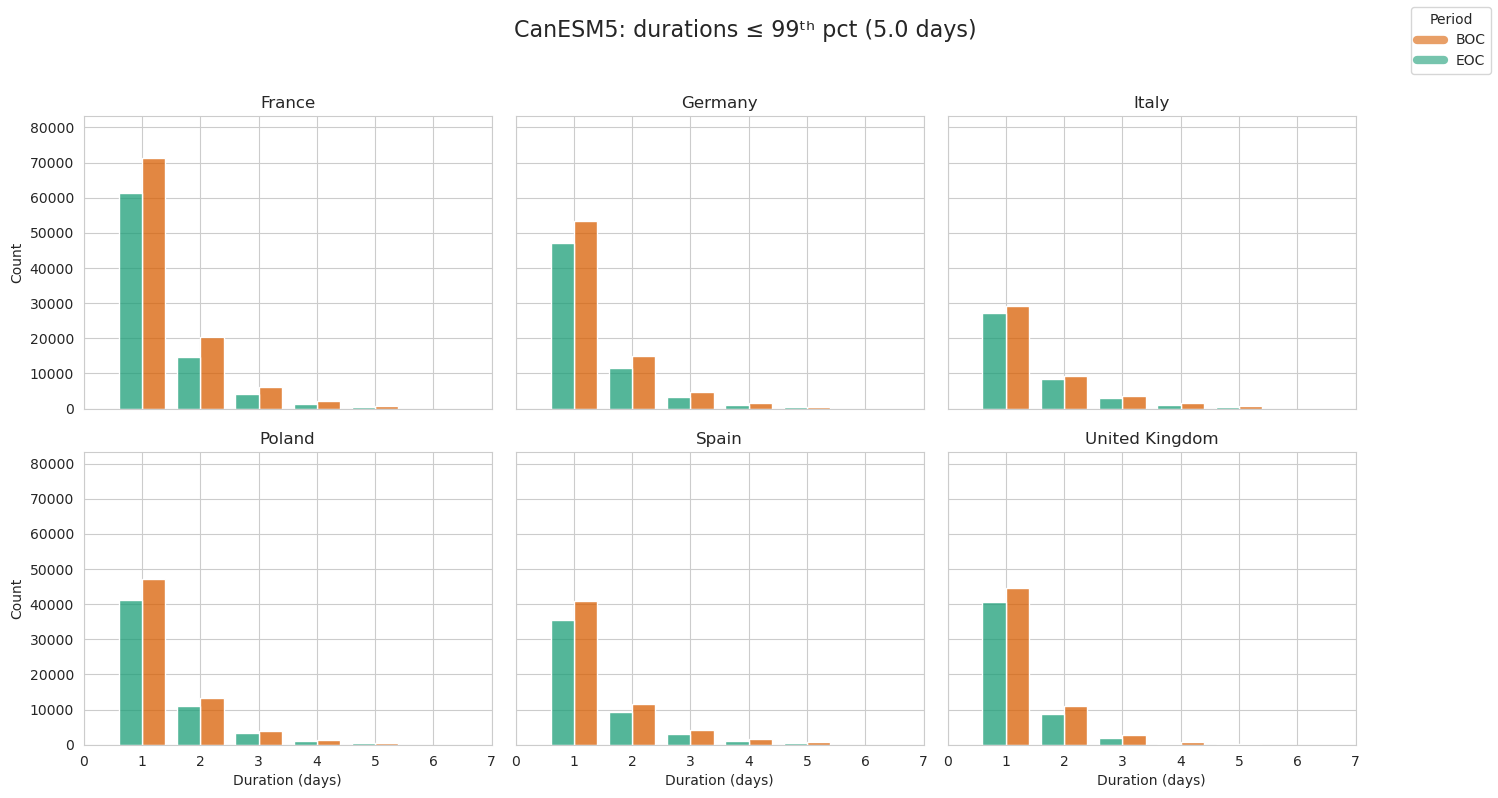

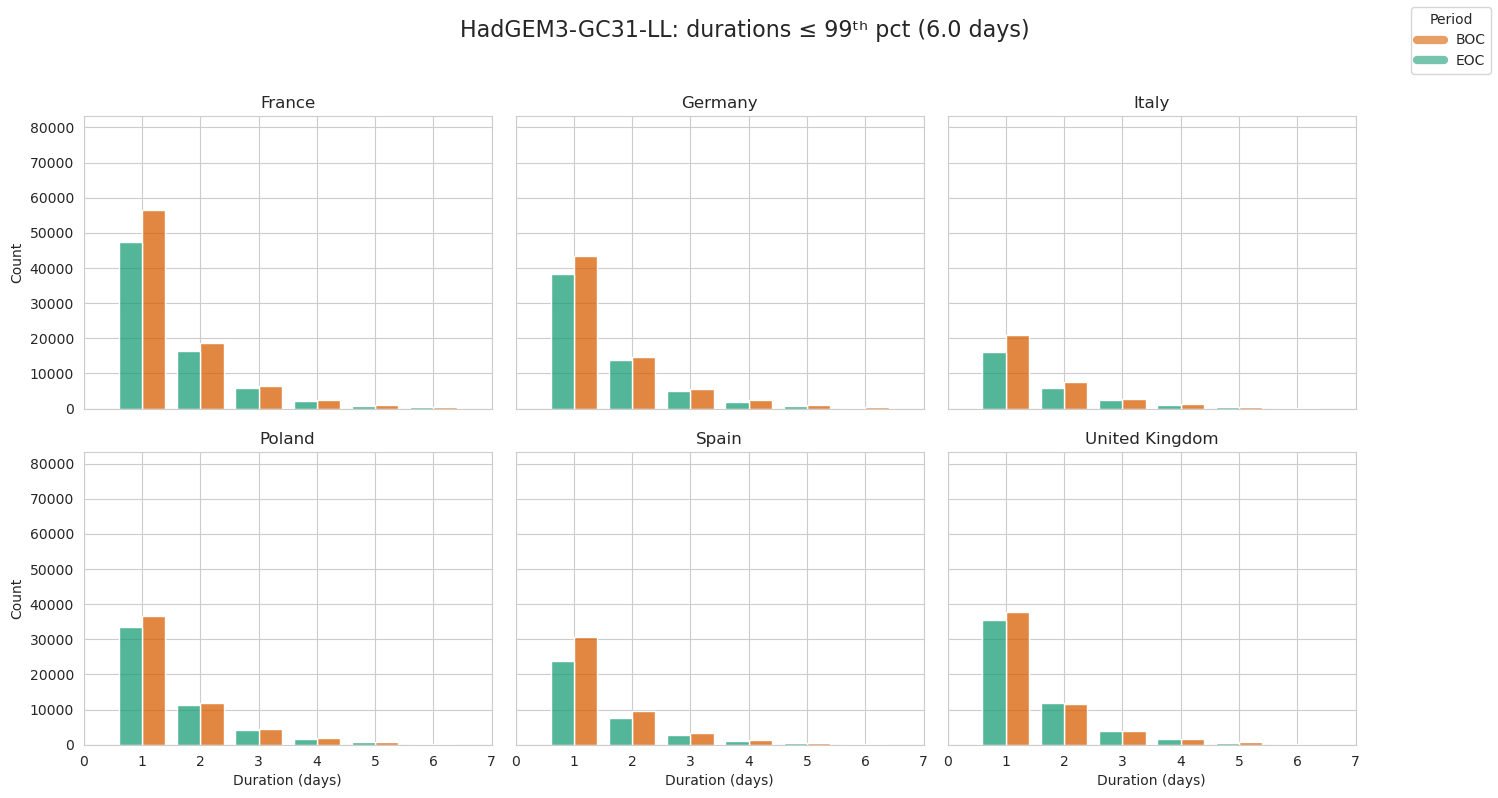

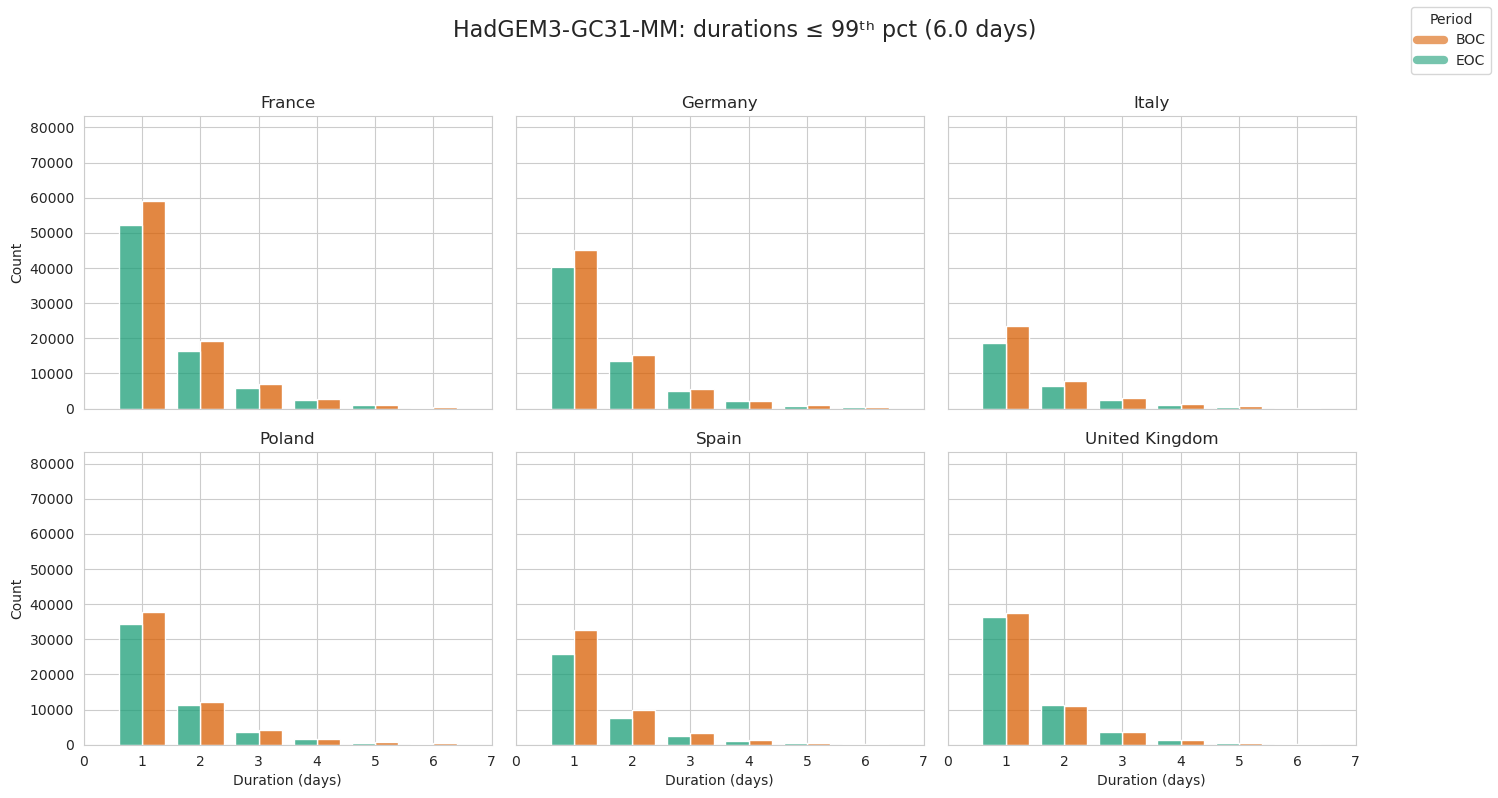

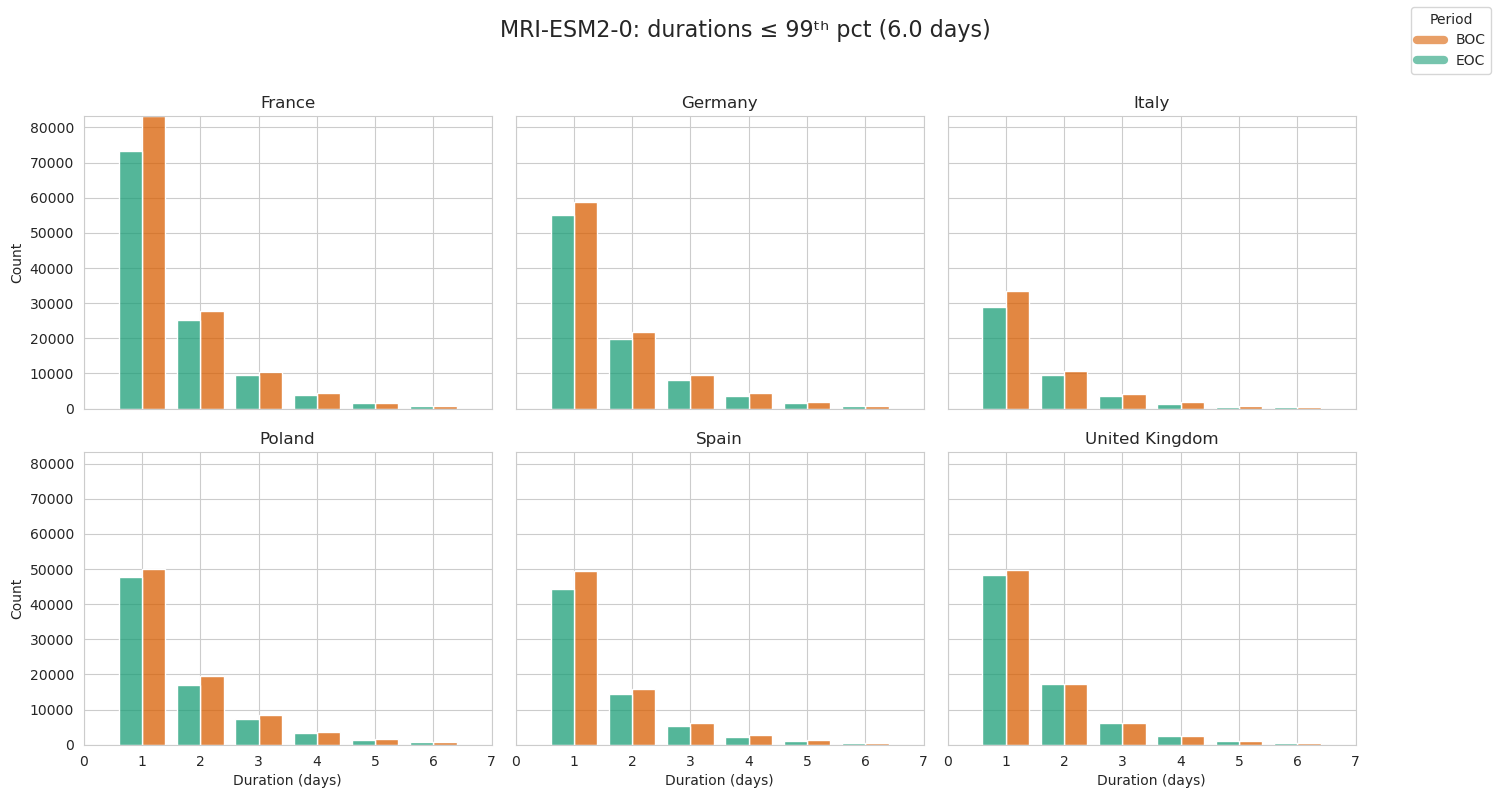

In [20]:
# 2) loop over models
for model in models:
    dfm   = events_with_country[events_with_country['model']==model]
    if dfm.empty:
        continue

    # model-specific 99th percentile & cut
    p99   = dfm['duration'].quantile(0.99)
    dfcut = dfm[dfm['duration'] <= p99]

    # 3) 2×3 grid of countries, shared x & y
    fig, axes = plt.subplots(2, 3,
                             figsize=(15, 8),
                             sharex=True,
                             sharey=True)
    axes = axes.flatten()

    for ax, country in zip(axes, countries):
        dfc = dfcut[dfcut['country'] == country]
        if dfc.empty:
            ax.set_title(f"{country}\n(no data)")
            continue

        sns.histplot(
            data=dfc,
            x='duration',
            discrete=True,
            hue='period',
            palette=colors,
            multiple='dodge',
            shrink=0.8,
            bins=bins,
            ax=ax,
            legend=False
        )

        ax.set_title(country)
        ax.set_xlim(0, global_p99)
        if global_ymax is not None:
            ax.set_ylim(0, global_ymax)
        ax.set_xlabel("Duration (days)")
        ax.set_ylabel("Count")

    # 4) common legend + title
    handles = [
        plt.Line2D([],[], color=col, lw=6, alpha=0.6)
        for col in colors.values()
    ]
    labels = list(colors.keys())
    fig.legend(handles, labels,
               title="Period",
               loc='upper right',
               frameon=True)
    fig.suptitle(
        f"{model}: durations ≤ 99ᵗʰ pct ({p99:.1f} days)",
        fontsize=16, y=0.98
    )

    plt.tight_layout(rect=[0,0,0.92,0.95])
    plt.show()

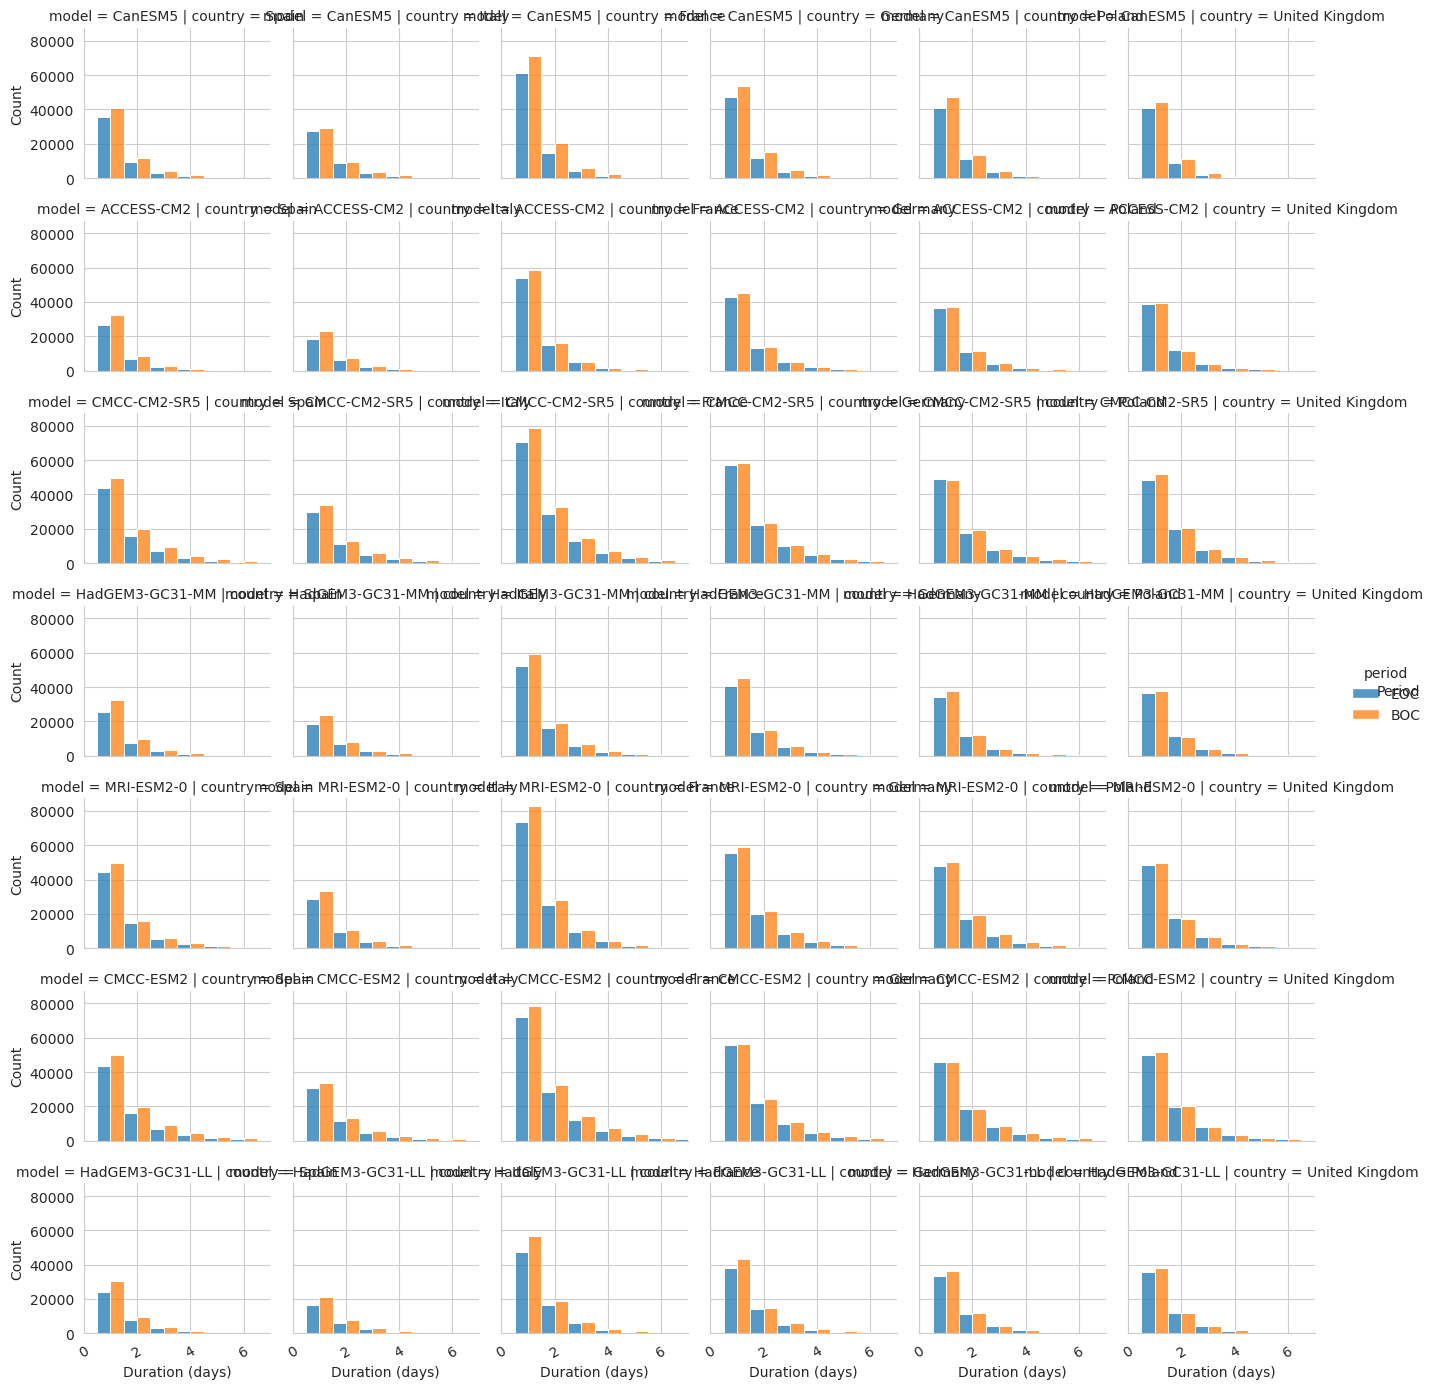

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) compute each model’s 99th‐pct and filter
df = events_with_country.copy()
df["cut99"] = df.groupby("model")["duration"] \
               .transform(lambda s: s.quantile(0.99))
df = df[df.duration <= df.cut99]

# 2) choose a common bin‐breaks up to the global max of those p99’s
global_max = df.cut99.max()
bins       = np.arange(0, global_max + 1, 1)

# 3) 6×n grid in one shot
g = sns.displot(
    data=df,
    x="duration",
    hue="period",
    row="model",
    col="country",
    kind="hist",
    discrete=True,
    multiple="dodge",
    bins=bins,
    height=2,
    aspect=1,
    facet_kws=dict(sharex=True, sharey=True)
)

# 4) polish
g.set_axis_labels("Duration (days)", "Count")
g.set(xlim=(0, global_max))
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30)
g.add_legend(title="Period")
plt.tight_layout()
plt.show()

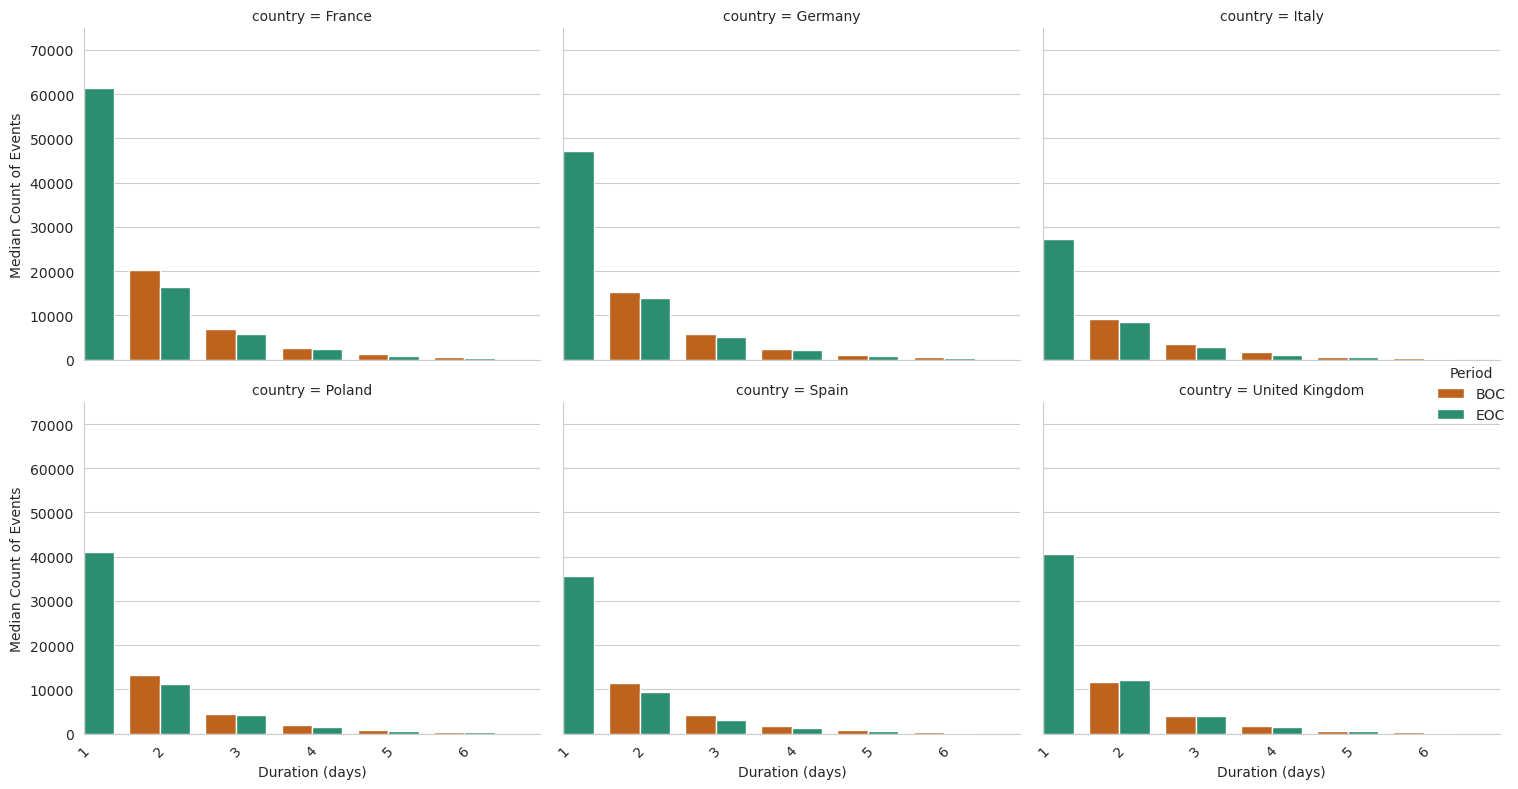

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) map country codes → names if you haven’t already
# events_with_country['country'] = events_with_country['country_code'].map(code_to_name)

# 1) clip at the global 99th percentile
p99 = events_with_country['duration'].quantile(0.99)
df = events_with_country[events_with_country['duration'] <= p99].copy()

# 2) count events per model×country×period×duration
cnt = (
    df
     .groupby(['model','country','period','duration'])
     .size()
     .reset_index(name='count')
)

# 3) pivot so missing durations → 0, then median over models
pivot = cnt.pivot_table(
    index=['model','country','period'],
    columns='duration',
    values='count',
    fill_value=0
)
med = (
    pivot
     .groupby(['country','period'])
     .median()         # median across models
     .reset_index()
     .melt(
         id_vars=['country','period'],
         var_name='duration',
         value_name='median_count'
     )
)
# compute the true global max
ymax = med['median_count'].max() * 1.05

g = sns.catplot(
    data=med,
    x='duration',
    y='median_count',
    hue='period',
    col='country',
    kind='bar',
    palette={'BOC':'#d95f02','EOC':'#1b9e77'},
    col_wrap=3,
    sharey=True,      # keep for direct comparison
    height=4,
    aspect=1.2,
    legend_out=True
)

# force the full y‐range
g.set(ylim=(0, ymax))

g.set_axis_labels("Duration (days)", "Median Count of Events")
for ax in g.axes.flatten():
    ax.set_xlim(0, p99)
    ax.tick_params(axis='x', rotation=45)
g._legend.set_title("Period")
plt.tight_layout()
plt.show()

In [25]:
med

,country,period,duration,median_count
0,France,BOC,1,71328.0
1,France,EOC,1,61353.0
2,Germany,BOC,1,53387.0
3,Germany,EOC,1,47082.0
4,Italy,BOC,1,29079.0
...,...,...,...,...
67,Poland,EOC,6,295.0
68,Spain,BOC,6,372.0
69,Spain,EOC,6,211.0
70,United Kingdom,BOC,6,327.0


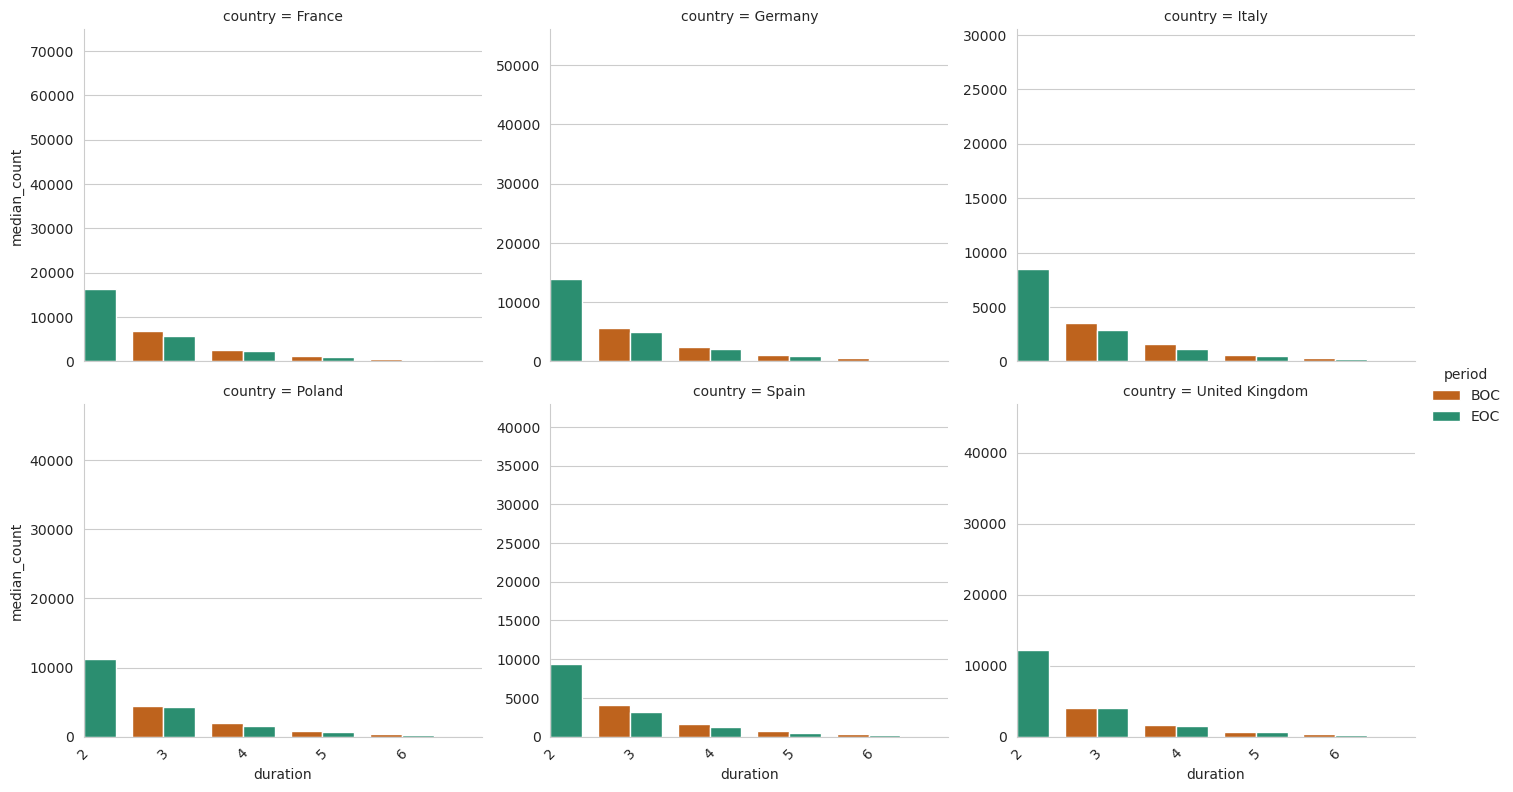

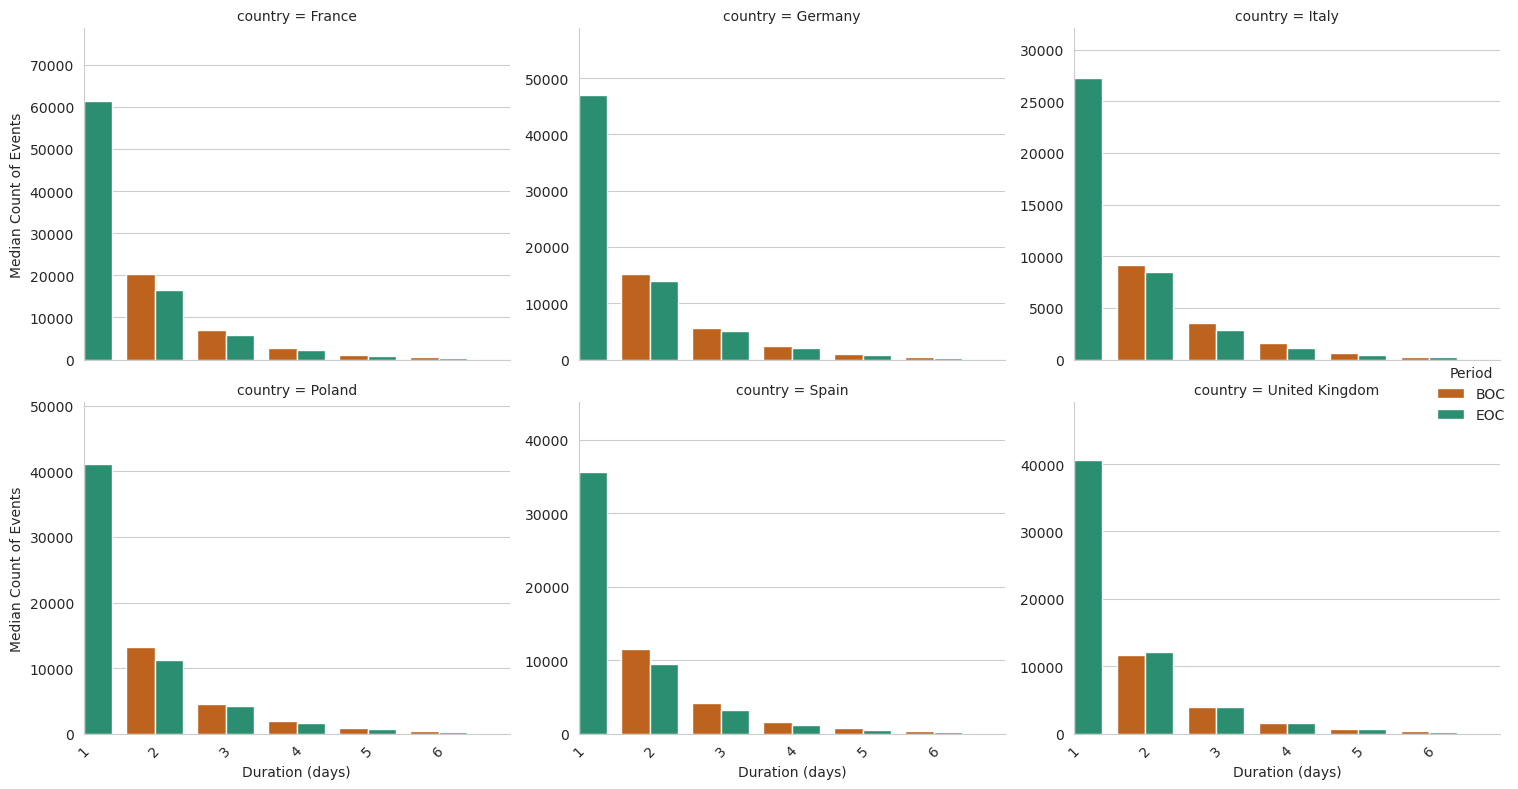

<Figure size 640x480 with 0 Axes>

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) (if needed) map country codes → names
# events_with_country['country'] = events_with_country['country_code'].map(code_to_name)

# 1) clip at the global 99th percentile
p99 = events_with_country['duration'].quantile(0.99)
df = events_with_country[events_with_country['duration'] <= p99].copy()

# 2) count events per model×country×period×duration
cnt = (
    df
     .groupby(['model','country','period','duration'])
     .size()
     .reset_index(name='count')
)

# 3) pivot so missing durations → 0, then median over models
pivot = cnt.pivot_table(
    index=['model','country','period'],
    columns='duration',
    values='count',
    fill_value=0
)
med = (
    pivot
     .groupby(['country','period'])
     .median()
     .reset_index()
     .melt(
         id_vars=['country','period'],
         var_name='duration',
         value_name='median_count'
     )
)

# 4) plot one bar‐chart per country, discrete durations, side‐by‐side BOC/EOC
sns.set_style('whitegrid')
g = sns.catplot(
    data=med,
    x='duration',
    y='median_count',
    hue='period',
    col='country',
    kind='bar',
    palette={'BOC':'#d95f02','EOC':'#1b9e77'},
    col_wrap=3,
    sharey=False,     # each facet scales its own y
    height=4,
    aspect=1.2,
    legend_out=True
)

# 5) force x‐limit to [0, p99]
for ax in g.axes.flatten():
    ax.set_xlim(1, p99)
    ax.tick_params(axis='x', rotation=45)

# 6) add a bit of top‐padding so no bar is clipped
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) (if needed) map country codes → names
# events_with_country['country'] = events_with_country['country_code'].map(code_to_name)

# 1) clip at the global 99th percentile
p99 = events_with_country['duration'].quantile(0.99)
df = events_with_country[events_with_country['duration'] <= p99].copy()

# 2) count events per model×country×period×duration
cnt = (
    df
     .groupby(['model','country','period','duration'])
     .size()
     .reset_index(name='count')
)

# 3) pivot so missing durations → 0, then median over models
pivot = cnt.pivot_table(
    index=['model','country','period'],
    columns='duration',
    values='count',
    fill_value=0
)
med = (
    pivot
     .groupby(['country','period'])
     .median()
     .reset_index()
     .melt(
         id_vars=['country','period'],
         var_name='duration',
         value_name='median_count'
     )
)

# 4) plot one bar‐chart per country, discrete durations, side‐by‐side BOC/EOC
sns.set_style('whitegrid')
g = sns.catplot(
    data=med,
    x='duration',
    y='median_count',
    hue='period',
    col='country',
    kind='bar',
    palette={'BOC':'#d95f02','EOC':'#1b9e77'},
    col_wrap=3,
    sharey=False,     # each facet scales its own y
    height=4,
    aspect=1.2,
    legend_out=True
)

# 5) force x‐limit to [0, p99]
for ax in g.axes.flatten():
    ax.set_xlim(0, p99)
    ax.tick_params(axis='x', rotation=45)

# 6) add a bit of top‐padding so no bar is clipped
for ax in g.axes.flatten():
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max*1.05)

g.set_axis_labels("Duration (days)", "Median Count of Events")
g._legend.set_title("Period")
plt.tight_layout()
plt.show()

g.set_axis_labels("Duration (days)", "Median Count of Events")
g._legend.set_title("Period")
plt.tight_layout()
plt.show()

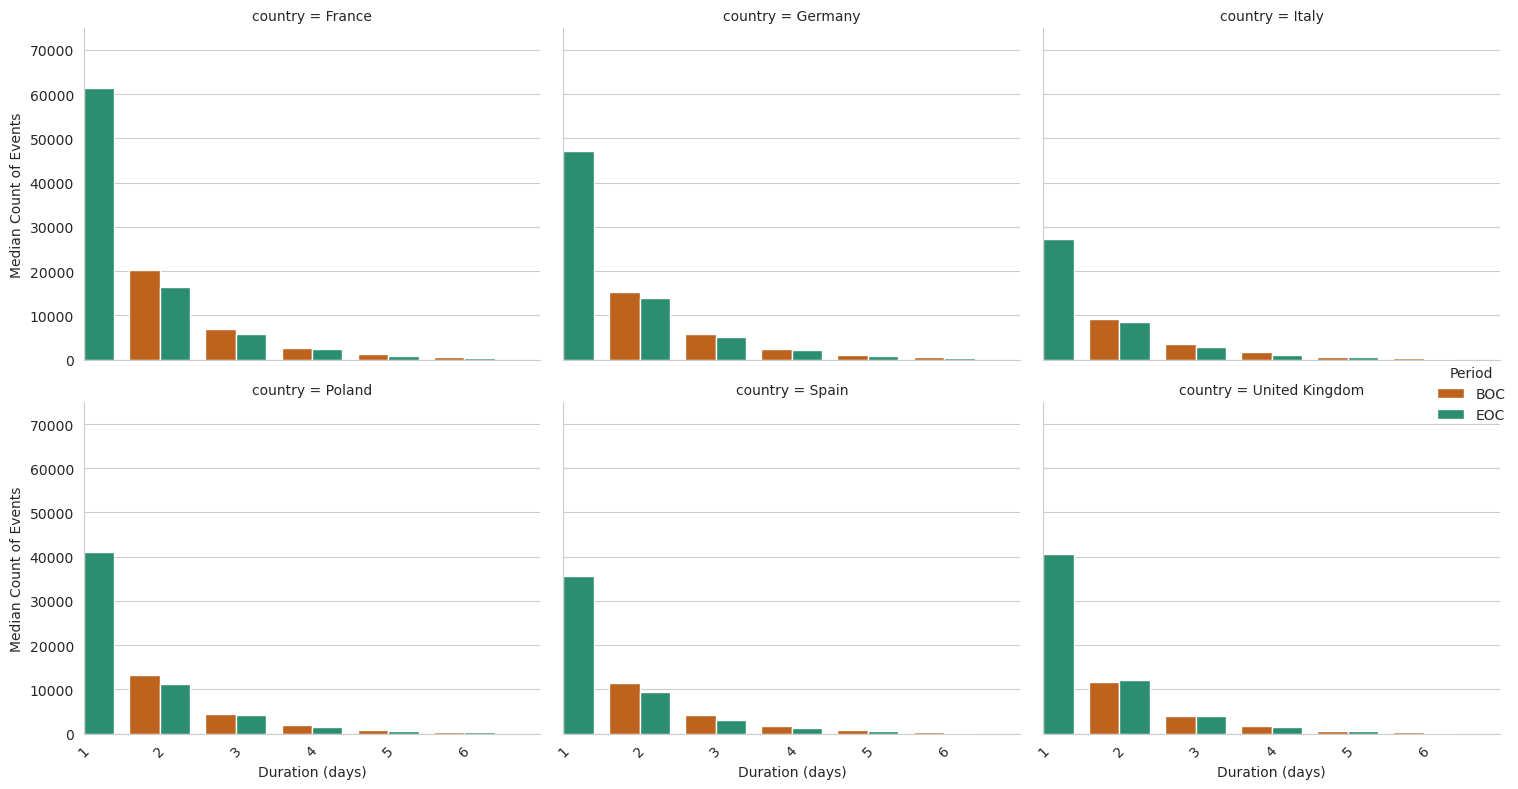

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) clip at 99th pct
p99 = events_with_country['duration'].quantile(0.99)
df  = events_with_country[events_with_country['duration'] <= p99]

# 2) per‐model counts
cnt = (
    df
    .groupby(['model','country','period','duration'])
    .size()
    .reset_index(name='count')
)

# 3) pivot & median across models
pivot = cnt.pivot_table(
    index=['model','country','period'],
    columns='duration',
    values='count',
    fill_value=0
)
med = (
    pivot
    .groupby(['country','period'])
    .median()
    .reset_index()
    .melt(
        id_vars=['country','period'],
        var_name='duration',
        value_name='median_count'
    )
)

# compute the global y‐max (across all countries & periods)
global_ymax = med['median_count'].max() * 1.05
max_int = int(np.floor(p99))

# make sure duration is integer
med['duration'] = med['duration'].astype(int)
dur_order = list(range(1, max_int+1))

# 4) discrete barplot faceted by country, side-by-side BOC/EOC
sns.set_style('whitegrid')
g = sns.catplot(
    data=med,
    x='duration',
    y='median_count',
    hue='period',
    col='country',
    kind='bar',
    order=dur_order, 
    palette={'BOC':'#d95f02','EOC':'#1b9e77'},
    col_wrap=3,
    sharey=True,      # ensure same y‐axis across facets
    height=4,
    aspect=1.2,
    legend_out=True
)

# 5) enforce common x‐ and y‐limits
for ax in g.axes.flatten():
    ax.set_xlim(0, p99)
g.set(ylim=(0, global_ymax))

# 6) polish
g.set_axis_labels("Duration (days)", "Median Count of Events")
g._legend.set_title("Period")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

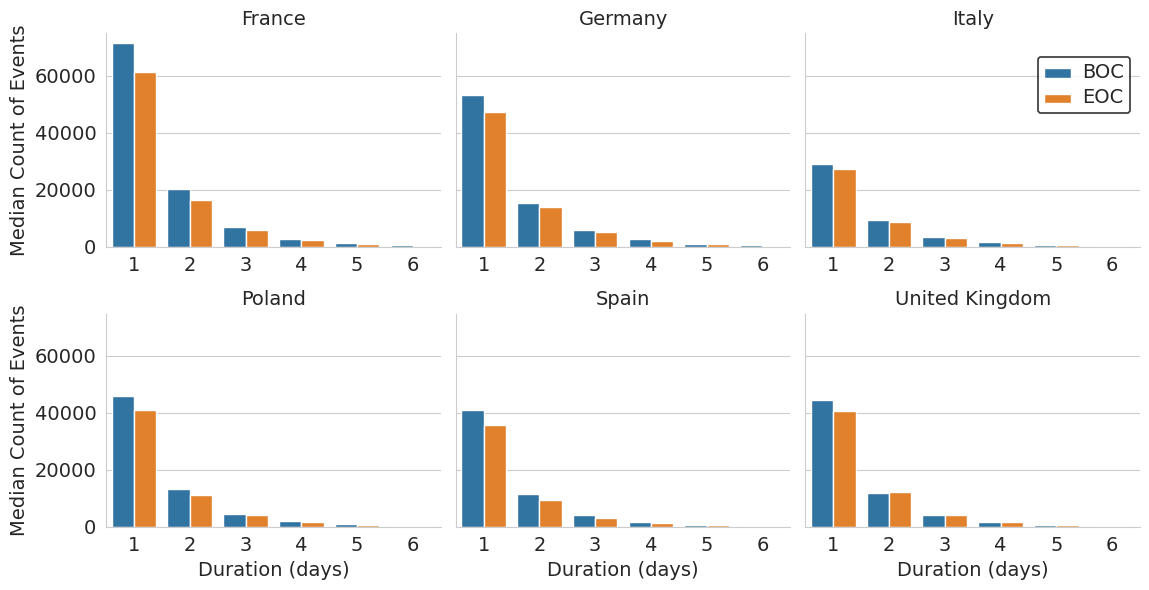

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) clip at 99th pct
p99 = events_with_country['duration'].quantile(0.99)
df   = events_with_country[events_with_country['duration']<=p99]

color_boc = "#1f77b4" # soft light blue
color_eoc= "#ff7f0e" 


# 2) count per model×country×period×duration
cnt = (
    df
    .groupby(['model','country','period','duration'])
    .size()
    .reset_index(name='count')
)

# 3) pivot so each row is one model/country/period, columns are durations
pivot = cnt.pivot_table(
    index=['model','country','period'],
    columns='duration',
    values='count',
    fill_value=0
)

# 4) now median *across models* for each country/period
med = (
    pivot
    .groupby(['country','period'])
    .median()
    .reset_index()
    .melt(
        id_vars=['country','period'],
        var_name='duration',
        value_name='median_count'
    )
)

# Make sure duration is integer and sorted
med['duration'] = med['duration'].astype(int)
dur_order = sorted(med['duration'].unique())  # e.g. [1,2,3,4,5,6]

# 3) Plot with explicit category order
sns.set_style('whitegrid')
# …your existing code up to the catplot() call…

g = sns.catplot(
    data=med,
    x='duration',
    y='median_count',
    hue='period',
    col='country',
    kind='bar',
    col_wrap=3,
    sharey=True,
    sharex=False,
    order=dur_order,
    hue_order=['BOC','EOC'],
    palette={"BOC": color_boc, "EOC": color_eoc},
    height=3,
    aspect=1.2,
    legend_out=True
)

# --- make everything fontsize=18 ---
# facet titles
g.set_titles("{col_name}", size=14)
# axis labels
g.set_axis_labels("Duration (days)", "Median Count of Events")
# tick labels + axis label fonts
for ax in g.axes.flatten():
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    #ax.set_xlabel("Duration (days)", fontsize=14)

# legend text & title
leg = g._legend
leg.set_title("", prop={'size':14})
for txt in leg.get_texts():
    txt.set_fontsize(14)
leg.set_frame_on(True)
leg.get_frame().set_edgecolor("black")
leg.get_frame().set_linewidth(1.2)
leg.get_frame().set_facecolor("white")   # or whatever background you like

# --- nudge its position ---
leg.set_loc("upper right")
leg.set_bbox_to_anchor((0.98, 0.9))      # (x0, y0) in figure coordinates


plt.tight_layout()
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/barplot_country_duration.pdf", bbox_inches='tight', dpi=300)
plt.show()

